Al estudiar un poco mejor el comportamiento de los RF, me he dado cuenta que lo que estaba usando para el Regressor era en realidad bagged trees y un RF de verdad. Ahora vamos a usar un RF a ver si los resultados de los notebook 6 y 7 mejoran considerablemente y si es así aplicarlo al resto de notebooks.

### 1. Primeros resultados e hiperparámetros (notebook 6)

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ctapipe.io import TableLoader

# RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Cargamos imágenes
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=1452118)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 'true_energy'
]

gamma_tel_events_f=gamma_tel_events[features]

# Convertimos a dataframe
df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()

X = df_gamma.drop("true_energy", axis=1)                                              # Determina los parámetros 
y = df_gamma["true_energy"]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [24]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.25)
rf2 = RandomForestRegressor(max_features = "sqrt")
rf2.fit(X_train2, y_train2)

RandomForestRegressor(max_features='sqrt')

In [ ]:
# Preparamos la representación
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')

In [26]:
# Hacemos predicciones con el modelo bagged trees:
y_pred = rf.predict(X_test)
 
# Evaluamos qué tal ha hecho las predicciones
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Squared Error: 109.22583414728668
R-squared: 0.7247535632694873


In [27]:
# Hacemos predicciones con el modelo RF:
y_pred2 = rf2.predict(X_test2)
 
# Evaluamos qué tal ha hecho las predicciones
mse2 = mean_squared_error(y_test2, y_pred2)
print(f'Mean Squared Error: {mse2}')
 
r22 = r2_score(y_test2, y_pred2)
print(f'R-squared: {r22}')

Mean Squared Error: 110.17034973586908
R-squared: 0.7253951556171854


/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


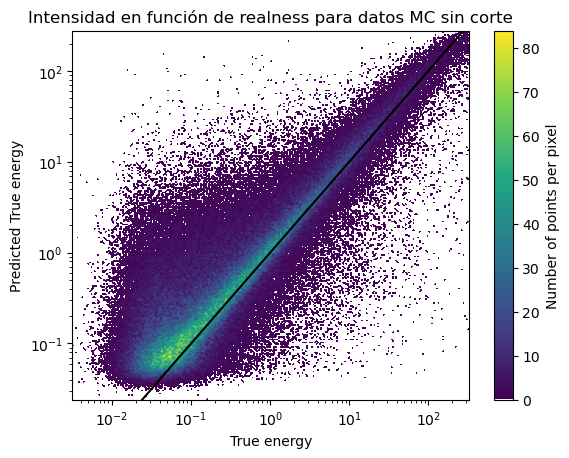

In [28]:
fig = plt.figure()
using_mpl_scatter_density(fig, y_test, y_pred)
plt.xlabel('True energy')
plt.ylabel('Predicted True energy')
plt.axline((1, 1), slope=1, c="k")
plt.yscale('log')
plt.xscale('log')
plt.title('Intensidad en función de realness para datos MC sin corte')
plt.show()

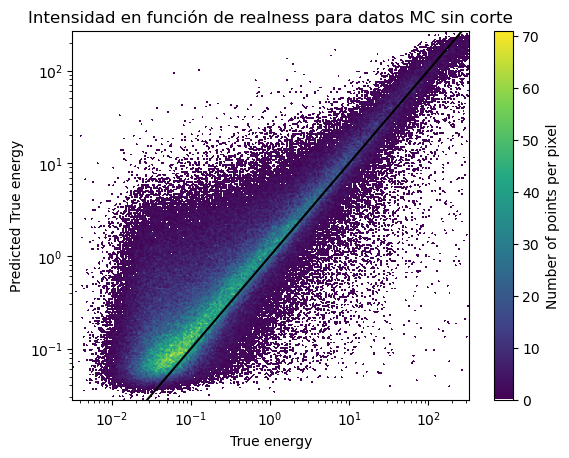

In [29]:
fig = plt.figure()
using_mpl_scatter_density(fig, y_test2, y_pred2)
plt.xlabel('True energy')
plt.ylabel('Predicted True energy')
plt.axline((1, 1), slope=1, c="k")
plt.yscale('log')
plt.xscale('log')
plt.title('Intensidad en función de realness para datos MC sin corte')
plt.show()

/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


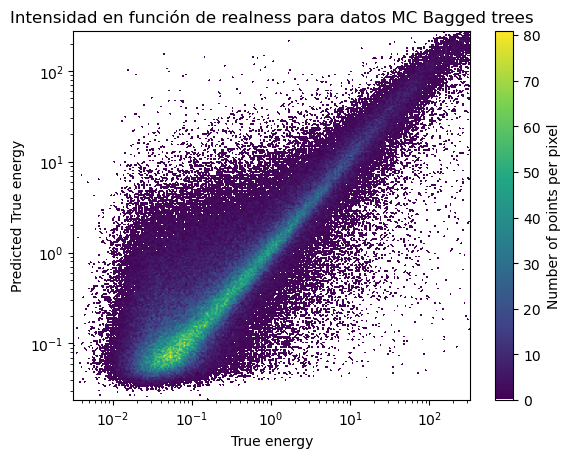

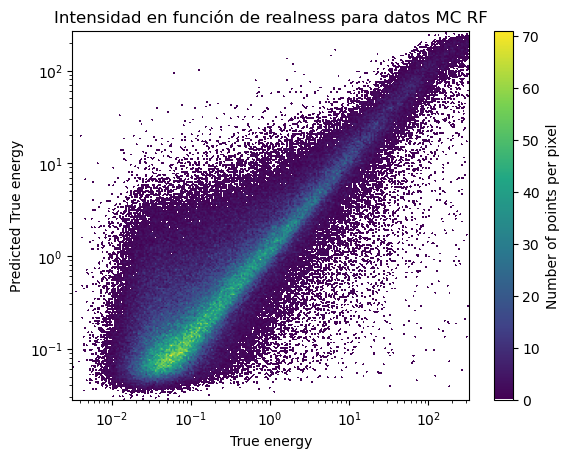

In [35]:
fig = plt.figure()
using_mpl_scatter_density(fig, y_test, y_pred)
plt.xlabel('True energy')
plt.ylabel('Predicted True energy')
plt.yscale('log')
plt.xscale('log')
plt.title('Intensidad en función de realness para datos MC Bagged trees')
plt.show()

fig = plt.figure()
using_mpl_scatter_density(fig, y_test2, y_pred2)
plt.xlabel('True energy')
plt.ylabel('Predicted True energy')
plt.yscale('log')
plt.xscale('log')
plt.title('Intensidad en función de realness para datos MC RF')
plt.show()

No hay una diferencia especialmente apreciable... seguimos aún así con el análisis

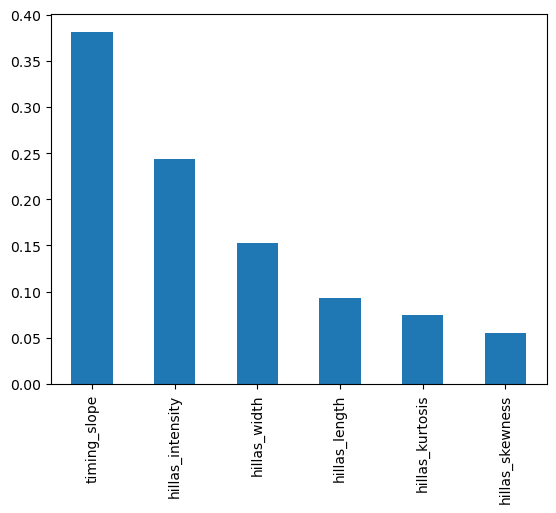

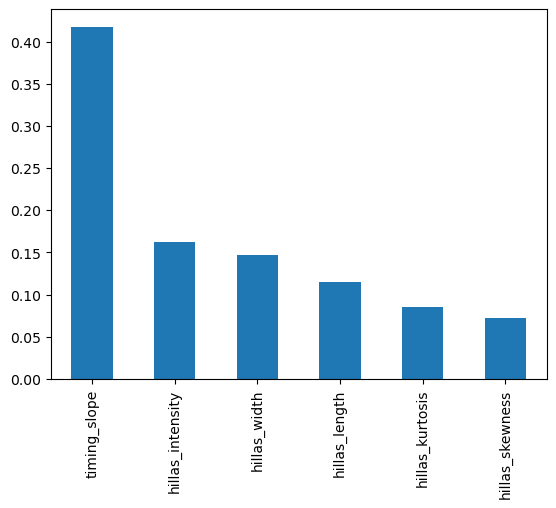

In [31]:
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()

feature_importances = pd.Series(rf2.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()

In [32]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.25)
rf3 = RandomForestRegressor(n_estimators=125, max_depth=19)
rf3.fit(X_train3, y_train3)

RandomForestRegressor(max_depth=19, n_estimators=125)

In [33]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=0.25)
rf4 = RandomForestRegressor(n_estimators=125, max_depth=19, max_features = "sqrt")
rf4.fit(X_train4, y_train4)

RandomForestRegressor(max_depth=19, max_features='sqrt', n_estimators=125)

In [34]:
# Hacemos predicciones con el modelo bagged trees:
y_pred3 = rf3.predict(X_test3)
 
# Evaluamos qué tal ha hecho las predicciones
mse3 = mean_squared_error(y_test3, y_pred3)
print(f'Mean Squared Error: {mse3}')
 
r23 = r2_score(y_test3, y_pred3)
print(f'R-squared: {r23}')

# Hacemos predicciones con el modelo RF:
y_pred4 = rf4.predict(X_test4)
 
# Evaluamos qué tal ha hecho las predicciones
mse4 = mean_squared_error(y_test4, y_pred4)
print(f'Mean Squared Error: {mse4}')
 
r24 = r2_score(y_test4, y_pred4)
print(f'R-squared: {r24}')

Mean Squared Error: 108.59417739961471
R-squared: 0.7299348330061386
Mean Squared Error: 107.11199014876921
R-squared: 0.7322155669451422


/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


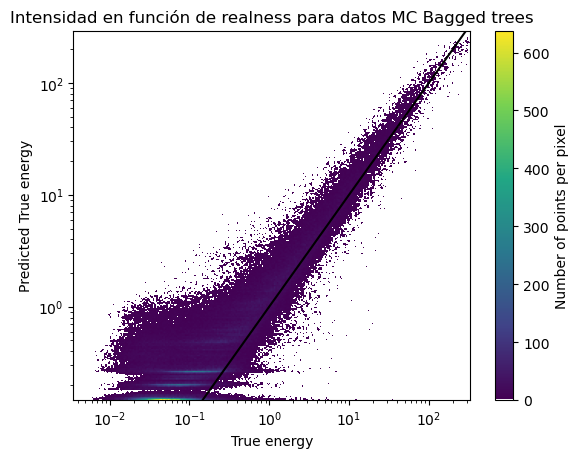

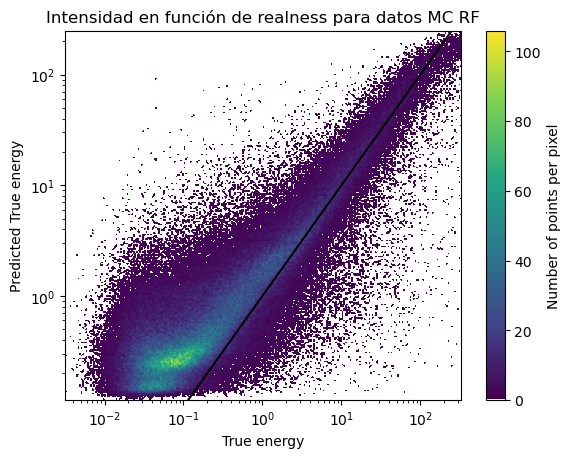

In [38]:
fig = plt.figure()
using_mpl_scatter_density(fig, y_test3, y_pred3)
plt.xlabel('True energy')
plt.ylabel('Predicted True energy')
plt.axline((1, 1), slope=1, c="k")
plt.yscale('log')
plt.xscale('log')
plt.title('Intensidad en función de realness para datos MC Bagged trees')
plt.show()

fig = plt.figure()
using_mpl_scatter_density(fig, y_test4, y_pred4)
plt.xlabel('True energy')
plt.ylabel('Predicted True energy')
plt.axline((1, 1), slope=1, c="k")
plt.yscale('log')
plt.xscale('log')
plt.title('Intensidad en función de realness para datos MC RF')
plt.show()

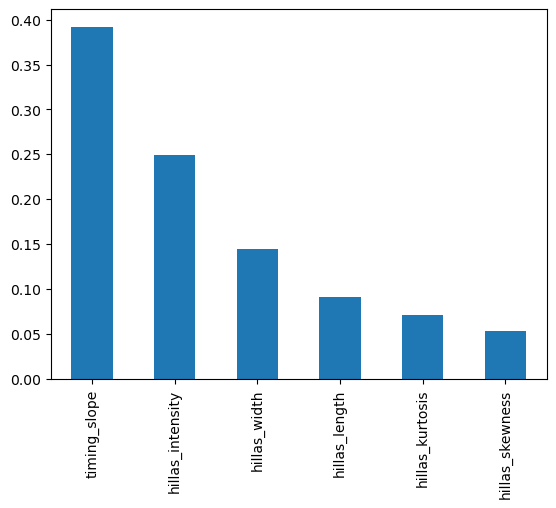

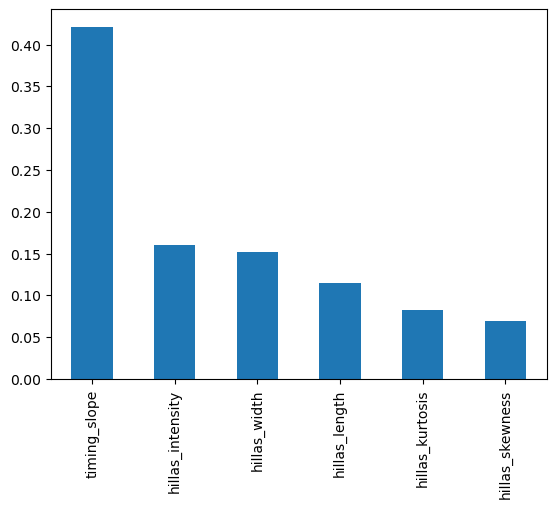

In [37]:
feature_importances = pd.Series(rf3.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()

feature_importances = pd.Series(rf4.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()

El underestimation poniendo un límite en la profundidad de los árboles es bastante evidente por lo que creo que me la voy a ahorrar.

Vamos a tocar los hiperparámetros a ver cómo mejora

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ctapipe.io import TableLoader

# RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Cargamos imágenes
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=50000)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 'true_energy'
]

gamma_tel_events_f=gamma_tel_events[features]

# Convertimos a dataframe
df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()

X = df_gamma.drop("true_energy", axis=1)                                              # Determina los parámetros 
y = df_gamma["true_energy"]

In [ ]:
nest = []
maxdep = []
R2 = []
MSD = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

n0_estimators = 50
for i in range(10):
    max0_depth = 2
    for j in range(30):
        rf = RandomForestRegressor(max_features = "sqrt", n_estimators = n0_estimators, max_depth = max0_depth)
        rf.fit(X_train, y_train)
        R2i = r2_score(y_test, rf.predict(X_test))
        MSDi = mean_squared_error(y_test, rf.predict(X_test))
        
        nest.append(n0_estimators)
        maxdep.append(max0_depth)
        R2.append(R2i)
        MSD.append(MSDi)
        
        max0_depth = max0_depth + 2
        print(R2i)    
    n0_estimators = n0_estimators + 25
    print()

0.24044426363590865
0.3849175255086471
0.47605182655007705
0.580282415190761
0.607888626495532
0.6300016137725091
0.6525728770302623
0.6600784202410412
0.650945129354086
0.6440347248413532
0.6664740935864646
0.660223611386711
0.6631244917027244
0.6567613721009242
0.6517895029401146
0.6572766591600923
0.6559158677889171
0.6542466515194199
0.6483710027616868
0.6455602782667789
0.650985819260461
0.6583811102898561
0.6678118714173027
0.6688947697630743
0.6636607972352206
0.6542064972276855
0.6585802489229051
0.666420989130116
0.6528751141538424
0.6569175321884535

0.23491277716851033
0.39379342203443735
0.507334622443659
0.5754400632385124
0.6196861195452256
0.6286415461530747
0.6464742185093395
0.6524712162746855
0.6619618002189255
0.6561883295953885
0.6615984363740801
0.6689097784910731
0.6577140686589281
0.658441649771531
0.6580937665522865
0.6700557826421548
0.660571286140891
0.6507670158385664
0.6576748542949757
0.6551640000259948
0.6648972768770468
0.6548754625601092
0.65957746355673

In [ ]:
# Representamos los resultados para ver gráficamente la precisión del modelo

ax = plt.axes(projection='3d') 
ax.scatter(maxdep, nest, R2, c=R2, cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, R2, c=R2, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, R2, c=R2, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 0)
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, R2, c=R2, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 90)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(nest, maxdep, R2, cmap="viridis", linewidth=0)
fig.colorbar(surf)
fig.tight_layout()
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(20, 30)
plt.show()

In [ ]:
# Representamos los resultados para ver gráficamente la MSD del modelo

ax = plt.axes(projection='3d') 
ax.scatter(maxdep, nest, MSD, c=MSD, cmap='viridis')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, MSD, c=MSD, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(90, 0)
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, MSD, c=MSD, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 0)
plt.show()

ax = plt.axes(projection='3d')
ax.scatter(nest, maxdep, MSD, c=MSD, cmap='viridis')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(0, 90)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_trisurf(nest, maxdep, MSD, cmap="viridis", linewidth=0)
fig.colorbar(surf)
fig.tight_layout()
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
ax.view_init(20, 30)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(maxdep, nest, R2, c=R2, cmap='viridis')
ax.view_init(15, -75)
ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
ax.set_zlabel('$R^2$')
plt.show()

fig.savefig('R2_Regr.png')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(maxdep, nest, MSD, c=MSD, cmap='viridis')
ax.view_init(15, -75)
ax.set_xlabel('max_depth')
ax.set_ylabel('n_estimators')
ax.set_zlabel('$MSE$')
plt.show()

fig.savefig('MSE_Regr.png')

### 2. Análisis más profundo (notebook 7)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ctapipe.io import TableLoader

# RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Cargamos imágenes
with TableLoader("../datos/gamma-diffuse.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g:
    gamma_tel_events = loader_g.read_telescope_events("LST_LST_LSTCam", start=0, stop=1450000)
with TableLoader("../datos/gamma-diffuse_with_images_00.dl2.h5", load_dl1_images=True,load_dl2=True, load_simulated=True) as loader_g2:
    gamma_tel_events2 = loader_g2.read_telescope_events("LST_LST_LSTCam", start=0, stop=25000)

# Determinamos los parámetros
features = [
 #'obs_id',
 #'event_id',                          
 #'tel_id',
 'hillas_intensity',
 'hillas_skewness',
 'hillas_kurtosis',
 #'hillas_r',
 #'hillas_phi',
 'hillas_length',
 'hillas_width',
 #'hillas_psi',
 #'timing_intercept',
 #'timing_deviation',
 'timing_slope',
 #'leakage_intensity_width_2',
 'true_energy'
]

gamma_tel_events_f = gamma_tel_events[features]
gamma_tel_events_f2 = gamma_tel_events2[features]

# Convertimos a dataframe
df_gamma = gamma_tel_events_f.to_pandas()
df_gamma = df_gamma.dropna()
df_gamma2 = gamma_tel_events_f2.to_pandas()
df_gamma2 = df_gamma2.dropna()

# Juntamos los dataframes
df_gammaT = pd.concat([df_gamma, df_gamma2], axis=0)   

X = df_gamma.drop("true_energy", axis=1)                                              # Determina los parámetros 
y = df_gamma["true_energy"]

/tmp/ipykernel_29255/1780342037.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Preparamos la representación
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
rf = RandomForestRegressor(max_features = "sqrt", n_estimators=150)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=150)

Mean Squared Error: 112.23789402052061
R-squared: 0.7277241838817258


/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


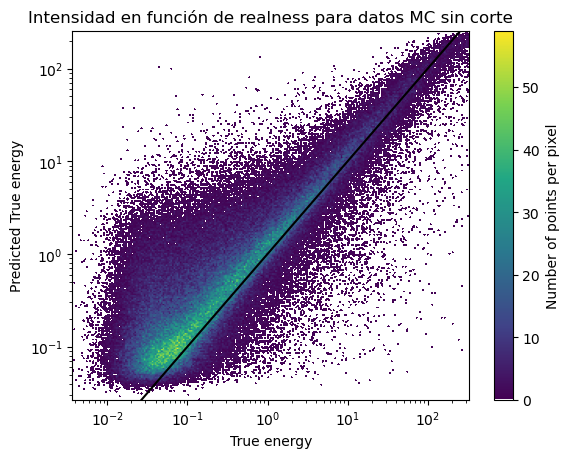

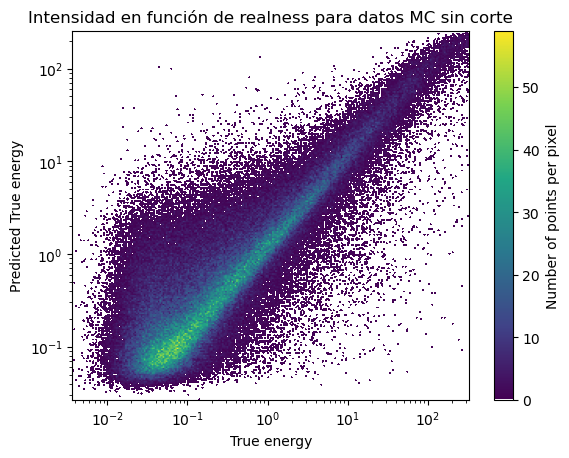

In [5]:
# Hacemos predicciones con el modelo:
y_pred = rf.predict(X_test)
 
# Evaluamos qué tal ha hecho las predicciones
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

fig = plt.figure()
using_mpl_scatter_density(fig, y_test, y_pred)
plt.xlabel('True energy')
plt.ylabel('Predicted True energy')
plt.axline((1, 1), slope=1, c="k")
plt.yscale('log')
plt.xscale('log')
plt.title('Intensidad en función de realness para datos MC sin corte')
plt.show()

fig = plt.figure()
using_mpl_scatter_density(fig, y_test, y_pred)
plt.xlabel('True energy')
plt.ylabel('Predicted True energy')
plt.yscale('log')
plt.xscale('log')
plt.title('Intensidad en función de realness para datos MC sin corte')
plt.show()

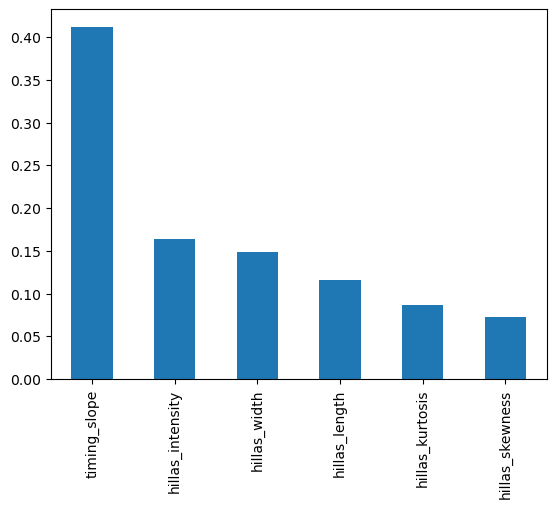

timing_slope        0.411696
hillas_intensity    0.164340
hillas_width        0.148919
hillas_length       0.116139
hillas_kurtosis     0.086581
hillas_skewness     0.072325
dtype: float64


In [6]:
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.show()

print(feature_importances)

In [13]:
for i in range(len(y_test)):
    for j in range(0, len(y_test)-i-1):
        if y_test[j] > y_test[j+1]:
            true_temp = y_test[j]
            y_test[j] = y_test[j+1]
            y_test[j+1] = true_temp

            pred_temp = y_pred[j]
            y_pred[j] = y_pred[j+1]
            y_pred[j+1] = pred_temp

In [14]:
# Vamos a guardar los resultados antes de nada

np.savetxt("y_test_orden_regr", y_test)
np.savetxt("y_pred_orden_regre", y_pred)

print(len(y_test))

162977


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ctapipe.io import TableLoader

# RandomForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Cargamos los datos
y_test = np.loadtxt("y_test_orden_regr")
y_pred = np.loadtxt("y_pred_orden_regre")

/tmp/ipykernel_17829/2482129150.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Preparamos la representación
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')

In [4]:
# Sacamos los arrays de valores reales
test1 = y_test[0:16250]
test2 = y_test[16250:32500]
test3 = y_test[32500:48750]
test4 = y_test[48750:65000]
test5 = y_test[65000:81250]
test6 = y_test[81250:97500]
test7 = y_test[97500:113750]
test8 = y_test[113750:130000]
test9 = y_test[130000:146250]
test10 = y_test[146250:162976]

# Sacamos los arrays de valores predichos
pred1 = y_pred[0:16250]
pred2 = y_pred[16250:32500]
pred3 = y_pred[32500:48750]
pred4 = y_pred[48750:65000]
pred5 = y_pred[65000:81250]
pred6 = y_pred[81250:97500]
pred7 = y_pred[97500:113750]
pred8 = y_pred[113750:130000]
pred9 = y_pred[130000:146250]
pred10 = y_pred[146250:162976]

Mean pred = 0.342665966620769
Standard Deviation pred = 0.8587001269710353
Skewness pred = 14.584167087007804
Kurtosis pred = 412.22489816411036
Mean test = 0.022437486635277476
Standard Deviation test = 0.006285972214691693
Skewness test = -0.4524400554726425
Kurtosis test = -0.6099024021754591


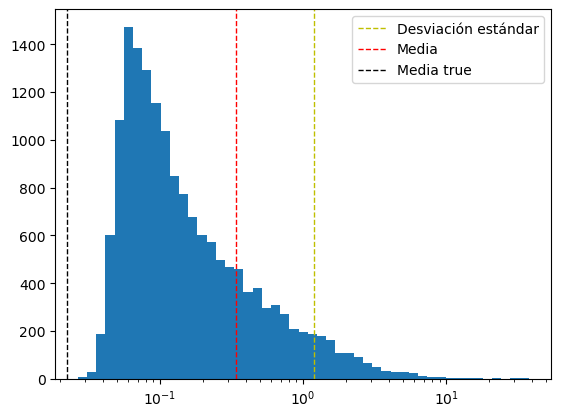

/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/gamma5/users/inimar2/anaconda3/envs/lst/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


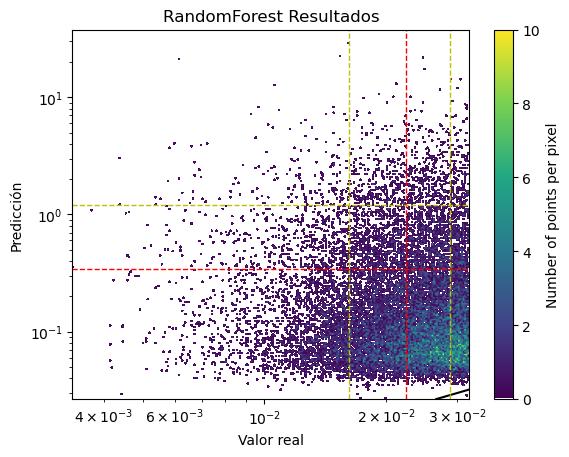

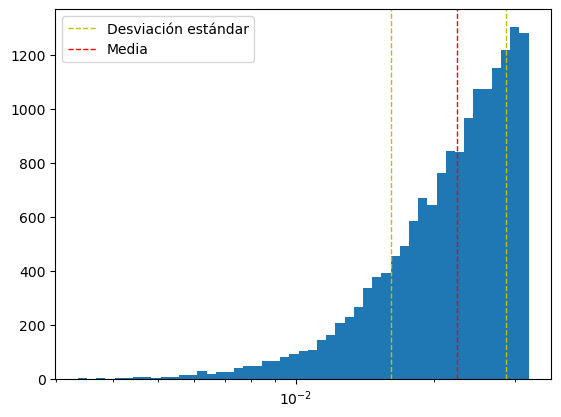

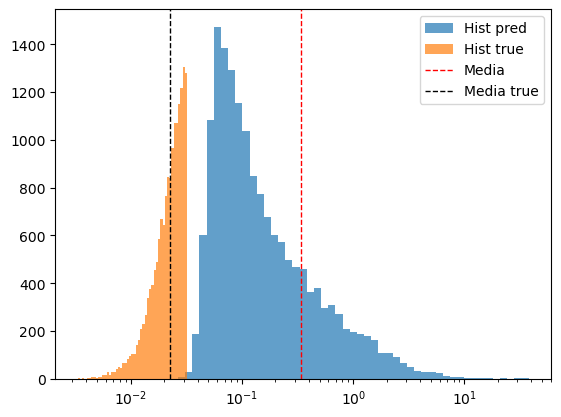

In [5]:
import scipy
from scipy import stats
media = []
errorx = []
errory = []
mediatrue = []

media1 = pred1.mean()
errory1 = pred1.std()
errorx1 = test1.std()
mediatrue1 = test1.mean()

# Calculamos los parámetros de la reconstrucción de energías
x_pred = np.linspace(media1 - 2*errory1, media1 + 2*errory1, 1000)
print ('Mean pred =', media1)
print ('Standard Deviation pred =', errory1)
print ('Skewness pred =', scipy.stats.skew(pred1))
print ('Kurtosis pred =', scipy.stats.kurtosis(pred1))

# Calculamos los parámetros de las energías verdaderas
x_test = np.linspace(mediatrue1 - 2*errorx1, mediatrue1 + 2*errorx1, 1000)
print ('Mean test =', mediatrue1)
print ('Standard Deviation test =', errorx1)
print ('Skewness test =', scipy.stats.skew(test1))
print ('Kurtosis test =', scipy.stats.kurtosis(test1))

# Represenatamos el histograma de la reconstrucción de energías
plt.hist(pred1, np.geomspace(pred1.min(), pred1.max(), num=50), range=(pred1.min(), pred1.max()))
plt.xscale('log')
plt.axvline(-errory1 + media1, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errory1 + media1, color='y', linestyle='dashed', linewidth=1)
plt.axvline(media1, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue1, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.legend()
plt.show()

# Representamos la reconstrucción frente a los valores reales
fig = plt.figure()
using_mpl_scatter_density(fig, test1, pred1)
plt.axline((1, 1), slope=1, c="k")
plt.title("RandomForest Resultados")
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.yscale('log')
plt.xscale('log')
plt.axvline(-errorx1 + mediatrue1, color='y', linestyle='dashed', linewidth=1, label='Std true')
plt.axvline(errorx1 + mediatrue1, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue1, color='r', linestyle='dashed', linewidth=1, label='Media true')
plt.axhline(-errory1 + media1, color='y', linestyle='dashed', linewidth=1, label='Std pred')
plt.axhline(errory1 + media1, color='y', linestyle='dashed', linewidth=1)
plt.axhline(media1, color='r', linestyle='dashed', linewidth=1, label='Media pred')
plt.xlim(test1.min(), test1.max())
plt.show()

# Representamos el histograma de las energías verdaderas
plt.hist(test1, np.geomspace(test1.min(), test1.max(), num=50), range=(test1.min(), test1.max()))
plt.xscale('log')
plt.axvline(-errorx1 + mediatrue1, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errorx1 + mediatrue1, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue1, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.legend()
plt.show()
plt.show()

# Representamos los dos histogramas
plt.hist(pred1, np.geomspace(pred1.min(), pred1.max(), num=50), range=(pred1.min(), pred1.max()), alpha = 0.7, label = 'Hist pred')
plt.hist(test1, np.geomspace(test1.min(), test1.max(), num=50), range=(test1.min(), test1.max()), alpha = 0.7, label = 'Hist true')
plt.xscale('log')
plt.axvline(media1, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue1, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.xscale('log')
plt.legend()
plt.show()

# Añadimos la media y los errores para el plot final
media.append(media1)
mediatrue.append(mediatrue1)
errory.append(errory1)
errorx.append(errorx1)

Mean pred = 0.3130703123957258
Standard Deviation pred = 0.7321303041730004
Skewness pred = 10.37397663450298
Kurtosis pred = 198.76483853210902
Mean test = 0.041441519788595345
Standard Deviation test = 0.005534083317488676
Skewness test = 0.0720548438372737
Kurtosis test = -1.185493150059726


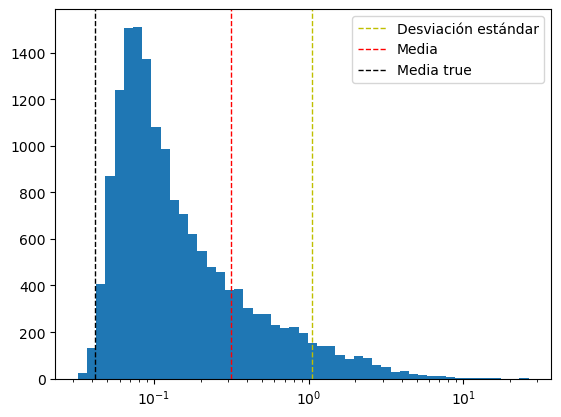

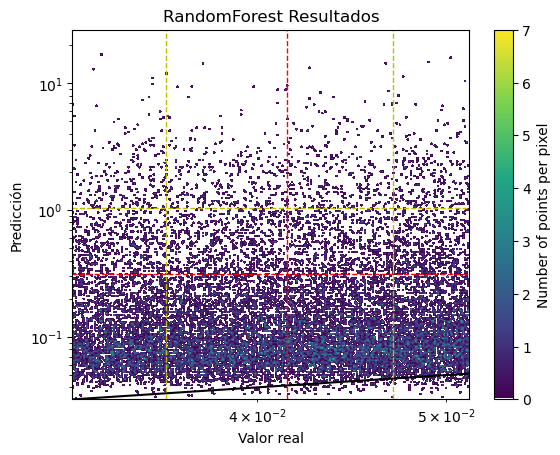

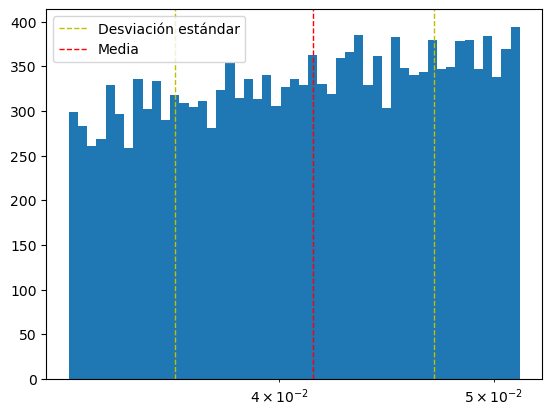

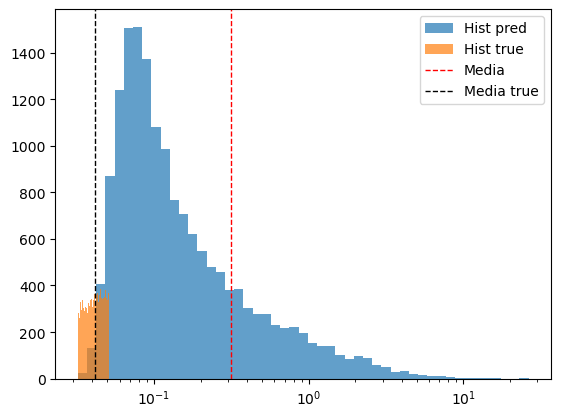

In [6]:
media2 = pred2.mean()
errory2 = pred2.std()
errorx2 = test2.std()
mediatrue2 = test2.mean()

# Calculamos los parámetros de la reconstrucción de energías
x_pred = np.linspace(media2 - 2*errory2, media2 + 2*errory2, 1000)
print ('Mean pred =', media2)
print ('Standard Deviation pred =', errory2)
print ('Skewness pred =', scipy.stats.skew(pred2))
print ('Kurtosis pred =', scipy.stats.kurtosis(pred2))

# Calculamos los parámetros de las energías verdaderas
x_test = np.linspace(mediatrue2 - 2*errorx2, mediatrue2 + 2*errorx2, 1000)
print ('Mean test =', mediatrue2)
print ('Standard Deviation test =', errorx2)
print ('Skewness test =', scipy.stats.skew(test2))
print ('Kurtosis test =', scipy.stats.kurtosis(test2))

# Represenatamos el histograma de la reconstrucción de energías
plt.hist(pred2, np.geomspace(pred2.min(), pred2.max(), num=50), range=(pred2.min(), pred2.max()))
plt.xscale('log')
plt.axvline(-errory2 + media2, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errory2 + media2, color='y', linestyle='dashed', linewidth=1)
plt.axvline(media2, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue2, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.legend()
plt.show()

# Representamos la reconstrucción frente a los valores reales
fig = plt.figure()
using_mpl_scatter_density(fig, test2, pred2)
plt.axline((1, 1), slope=1, c="k")
plt.title("RandomForest Resultados")
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.yscale('log')
plt.xscale('log')
plt.axvline(-errorx2 + mediatrue2, color='y', linestyle='dashed', linewidth=1, label='Std true')
plt.axvline(errorx2 + mediatrue2, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue2, color='r', linestyle='dashed', linewidth=1, label='Media true')
plt.axhline(-errory2 + media2, color='y', linestyle='dashed', linewidth=1, label='Std pred')
plt.axhline(errory2 + media2, color='y', linestyle='dashed', linewidth=1)
plt.axhline(media2, color='r', linestyle='dashed', linewidth=1, label='Media pred')
plt.xlim(test2.min(), test2.max())
plt.show()

# Representamos el histograma de las energías verdaderas
plt.hist(test2, np.geomspace(test2.min(), test2.max(), num=50), range=(test2.min(), test2.max()))
plt.xscale('log')
plt.axvline(-errorx2 + mediatrue2, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errorx2 + mediatrue2, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue2, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.legend()
plt.show()
plt.show()

# Representamos los dos histogramas
plt.hist(pred2, np.geomspace(pred2.min(), pred2.max(), num=50), range=(pred2.min(), pred2.max()), alpha = 0.7, label = 'Hist pred')
plt.hist(test2, np.geomspace(test2.min(), test2.max(), num=50), range=(test2.min(), test2.max()), alpha = 0.7, label = 'Hist true')
plt.xscale('log')
plt.axvline(media2, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue2, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.xscale('log')
plt.legend()
plt.show()

# Añadimos la media y los errores para el plot final
media.append(media2)
mediatrue.append(mediatrue2)
errory.append(errory2)
errorx.append(errorx2)

Mean pred = 0.3325276684961706
Standard Deviation pred = 1.3093438292925896
Skewness pred = 50.611285954934246
Kurtosis pred = 4110.645269925596
Mean test = 0.06382047934188292
Standard Deviation test = 0.007589331918651498
Skewness test = 0.12155488070526313
Kurtosis test = -1.1783064432568526


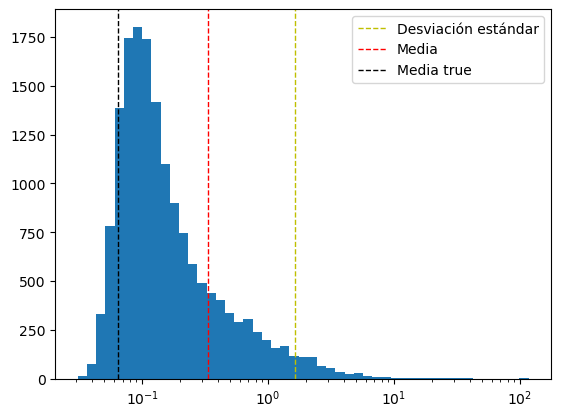

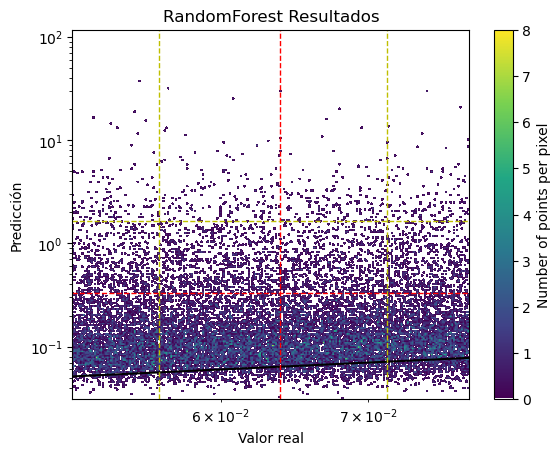

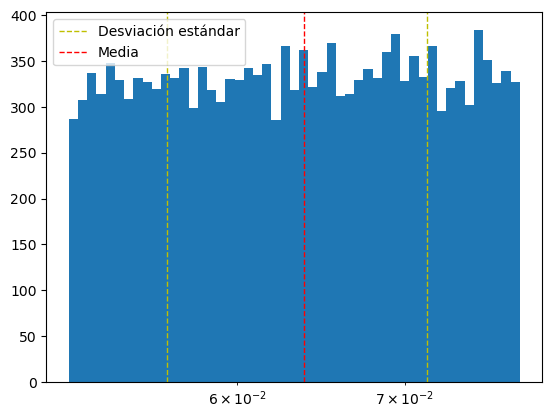

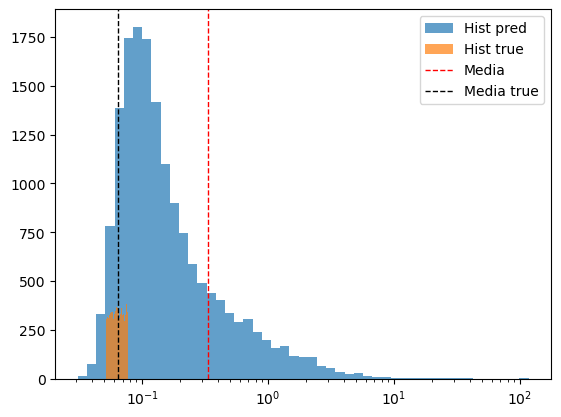

In [7]:
media3 = pred3.mean()
errory3 = pred3.std()
errorx3 = test3.std()
mediatrue3 = test3.mean()

# Calculamos los parámetros de la reconstrucción de energías
x_pred = np.linspace(media3 - 2*errory3, media3 + 2*errory3, 1000)
print ('Mean pred =', media3)
print ('Standard Deviation pred =', errory3)
print ('Skewness pred =', scipy.stats.skew(pred3))
print ('Kurtosis pred =', scipy.stats.kurtosis(pred3))

# Calculamos los parámetros de las energías verdaderas
x_test = np.linspace(mediatrue3 - 2*errorx3, mediatrue3 + 2*errorx3, 1000)
print ('Mean test =', mediatrue3)
print ('Standard Deviation test =', errorx3)
print ('Skewness test =', scipy.stats.skew(test3))
print ('Kurtosis test =', scipy.stats.kurtosis(test3))

# Represenatamos el histograma de la reconstrucción de energías
plt.hist(pred3, np.geomspace(pred3.min(), pred3.max(), num=50), range=(pred3.min(), pred3.max()))
plt.xscale('log')
plt.axvline(-errory3 + media3, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errory3 + media3, color='y', linestyle='dashed', linewidth=1)
plt.axvline(media3, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue3, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.legend()
plt.show()

# Representamos la reconstrucción frente a los valores reales
fig = plt.figure()
using_mpl_scatter_density(fig, test3, pred3)
plt.axline((1, 1), slope=1, c="k")
plt.title("RandomForest Resultados")
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.yscale('log')
plt.xscale('log')
plt.axvline(-errorx3 + mediatrue3, color='y', linestyle='dashed', linewidth=1, label='Std true')
plt.axvline(errorx3 + mediatrue3, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue3, color='r', linestyle='dashed', linewidth=1, label='Media true')
plt.axhline(-errory3 + media3, color='y', linestyle='dashed', linewidth=1, label='Std pred')
plt.axhline(errory3 + media3, color='y', linestyle='dashed', linewidth=1)
plt.axhline(media3, color='r', linestyle='dashed', linewidth=1, label='Media pred')
plt.xlim(test3.min(), test3.max())
plt.show()

# Representamos el histograma de las energías verdaderas
plt.hist(test3, np.geomspace(test3.min(), test3.max(), num=50), range=(test3.min(), test3.max()))
plt.xscale('log')
plt.axvline(-errorx3 + mediatrue3, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errorx3 + mediatrue3, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue3, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.legend()
plt.show()
plt.show()

# Representamos los dos histogramas
plt.hist(pred3, np.geomspace(pred3.min(), pred3.max(), num=50), range=(pred3.min(), pred3.max()), alpha = 0.7, label = 'Hist pred')
plt.hist(test3, np.geomspace(test3.min(), test3.max(), num=50), range=(test3.min(), test3.max()), alpha = 0.7, label = 'Hist true')
plt.xscale('log')
plt.axvline(media3, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue3, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.xscale('log')
plt.legend()
plt.show()

# Añadimos la media y los errores para el plot final
media.append(media3)
mediatrue.append(mediatrue3)
errory.append(errory3)
errorx.append(errorx3)

Mean pred = 0.3710845468487242
Standard Deviation pred = 0.8912925459675959
Skewness pred = 14.509484686149525
Kurtosis pred = 362.73731351116476
Mean test = 0.097482476323843
Standard Deviation test = 0.012329495810375924
Skewness test = 0.16807894958019978
Kurtosis test = -1.1614676433328603


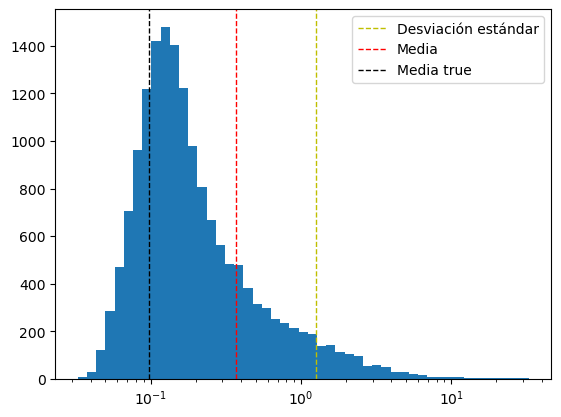

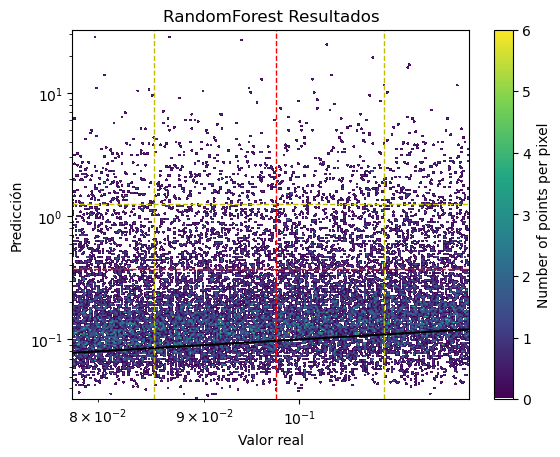

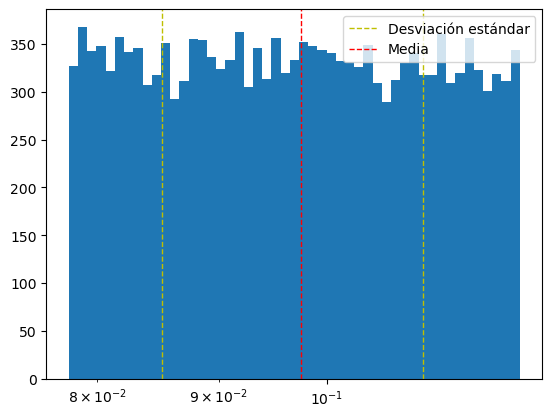

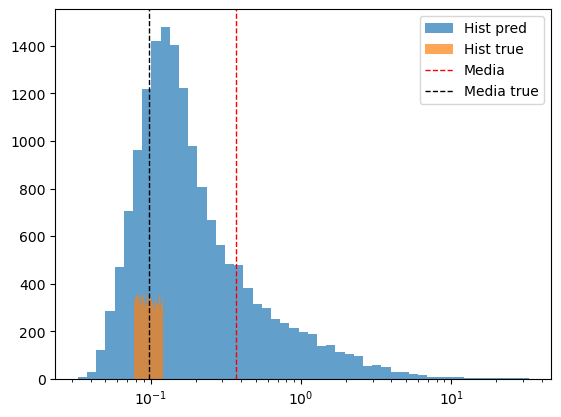

In [8]:
media4 = pred4.mean()
errory4 = pred4.std()
errorx4 = test4.std()
mediatrue4 = test4.mean()

# Calculamos los parámetros de la reconstrucción de energías
x_pred = np.linspace(media4 - 2*errory4, media4 + 2*errory4, 1000)
print ('Mean pred =', media4)
print ('Standard Deviation pred =', errory4)
print ('Skewness pred =', scipy.stats.skew(pred4))
print ('Kurtosis pred =', scipy.stats.kurtosis(pred4))

# Calculamos los parámetros de las energías verdaderas
x_test = np.linspace(mediatrue4 - 2*errorx4, mediatrue4 + 2*errorx4, 1000)
print ('Mean test =', mediatrue4)
print ('Standard Deviation test =', errorx4)
print ('Skewness test =', scipy.stats.skew(test4))
print ('Kurtosis test =', scipy.stats.kurtosis(test4))

# Represenatamos el histograma de la reconstrucción de energías
plt.hist(pred4, np.geomspace(pred4.min(), pred4.max(), num=50), range=(pred4.min(), pred4.max()))
plt.xscale('log')
plt.axvline(-errory4 + media4, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errory4 + media4, color='y', linestyle='dashed', linewidth=1)
plt.axvline(media4, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue4, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.legend()
plt.show()

# Representamos la reconstrucción frente a los valores reales
fig = plt.figure()
using_mpl_scatter_density(fig, test4, pred4)
plt.axline((1, 1), slope=1, c="k")
plt.title("RandomForest Resultados")
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.yscale('log')
plt.xscale('log')
plt.axvline(-errorx4 + mediatrue4, color='y', linestyle='dashed', linewidth=1, label='Std true')
plt.axvline(errorx4 + mediatrue4, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue4, color='r', linestyle='dashed', linewidth=1, label='Media true')
plt.axhline(-errory4 + media4, color='y', linestyle='dashed', linewidth=1, label='Std pred')
plt.axhline(errory4 + media4, color='y', linestyle='dashed', linewidth=1)
plt.axhline(media4, color='r', linestyle='dashed', linewidth=1, label='Media pred')
plt.xlim(test4.min(), test4.max())
plt.show()

# Representamos el histograma de las energías verdaderas
plt.hist(test4, np.geomspace(test4.min(), test4.max(), num=50), range=(test4.min(), test4.max()))
plt.xscale('log')
plt.axvline(-errorx4 + mediatrue4, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errorx4 + mediatrue4, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue4, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.legend()
plt.show()
plt.show()

# Representamos los dos histogramas
plt.hist(pred4, np.geomspace(pred4.min(), pred4.max(), num=50), range=(pred4.min(), pred4.max()), alpha = 0.7, label = 'Hist pred')
plt.hist(test4, np.geomspace(test4.min(), test4.max(), num=50), range=(test4.min(), test4.max()), alpha = 0.7, label = 'Hist true')
plt.xscale('log')
plt.axvline(media4, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue4, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.xscale('log')
plt.legend()
plt.show()

# Añadimos la media y los errores para el plot final
media.append(media4)
mediatrue.append(mediatrue4)
errory.append(errory4)
errorx.append(errorx4)

Mean pred = 0.5017306226925714
Standard Deviation pred = 1.38677038473693
Skewness pred = 37.67548792051267
Kurtosis pred = 2643.246978147637
Mean test = 0.15440968079704503
Standard Deviation test = 0.02151084522520171
Skewness test = 0.20180186260828398
Kurtosis test = -1.1450330098307409


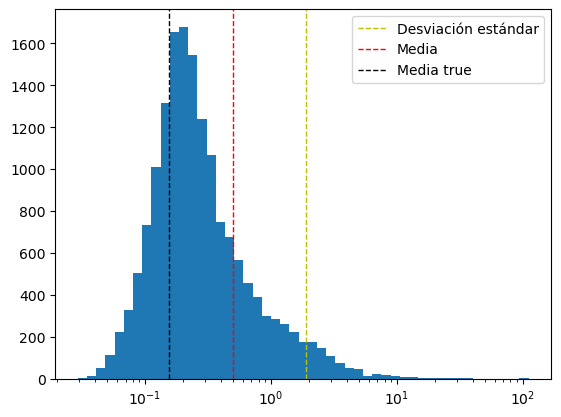

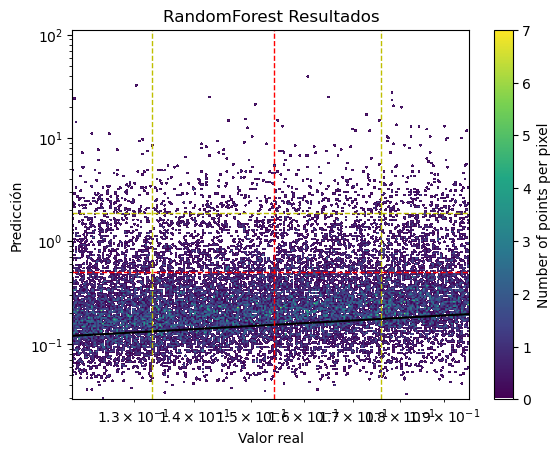

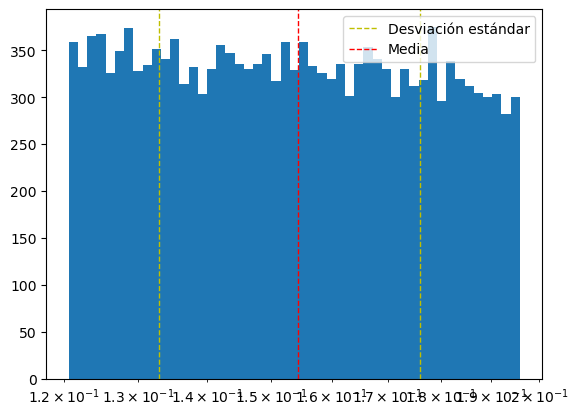

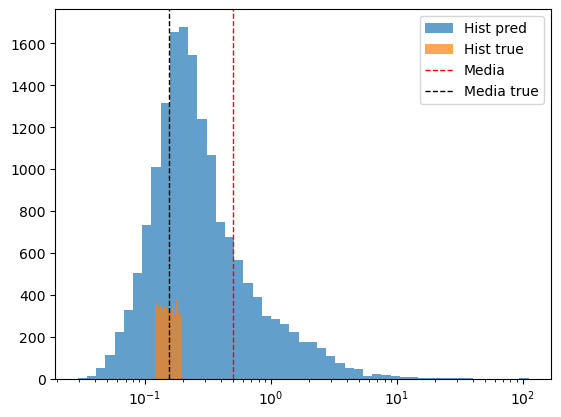

In [9]:
media5 = pred5.mean()
errory5 = pred5.std()
errorx5 = test5.std()
mediatrue5 = test5.mean()

# Calculamos los parámetros de la reconstrucción de energías
x_pred = np.linspace(media5 - 2*errory5, media5 + 2*errory5, 1000)
print ('Mean pred =', media5)
print ('Standard Deviation pred =', errory5)
print ('Skewness pred =', scipy.stats.skew(pred5))
print ('Kurtosis pred =', scipy.stats.kurtosis(pred5))

# Calculamos los parámetros de las energías verdaderas
x_test = np.linspace(mediatrue5 - 2*errorx5, mediatrue5 + 2*errorx5, 1000)
print ('Mean test =', mediatrue5)
print ('Standard Deviation test =', errorx5)
print ('Skewness test =', scipy.stats.skew(test5))
print ('Kurtosis test =', scipy.stats.kurtosis(test5))

# Represenatamos el histograma de la reconstrucción de energías
plt.hist(pred5, np.geomspace(pred5.min(), pred5.max(), num=50), range=(pred5.min(), pred5.max()))
plt.xscale('log')
plt.axvline(-errory5 + media5, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errory5 + media5, color='y', linestyle='dashed', linewidth=1)
plt.axvline(media5, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue5, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.legend()
plt.show()

# Representamos la reconstrucción frente a los valores reales
fig = plt.figure()
using_mpl_scatter_density(fig, test5, pred5)
plt.axline((1, 1), slope=1, c="k")
plt.title("RandomForest Resultados")
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.yscale('log')
plt.xscale('log')
plt.axvline(-errorx5 + mediatrue5, color='y', linestyle='dashed', linewidth=1, label='Std true')
plt.axvline(errorx5 + mediatrue5, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue5, color='r', linestyle='dashed', linewidth=1, label='Media true')
plt.axhline(-errory5 + media5, color='y', linestyle='dashed', linewidth=1, label='Std pred')
plt.axhline(errory5 + media5, color='y', linestyle='dashed', linewidth=1)
plt.axhline(media5, color='r', linestyle='dashed', linewidth=1, label='Media pred')
plt.xlim(test5.min(), test5.max())
plt.show()

# Representamos el histograma de las energías verdaderas
plt.hist(test5, np.geomspace(test5.min(), test5.max(), num=50), range=(test5.min(), test5.max()))
plt.xscale('log')
plt.axvline(-errorx5 + mediatrue5, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errorx5 + mediatrue5, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue5, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.legend()
plt.show()
plt.show()

# Representamos los dos histogramas
plt.hist(pred5, np.geomspace(pred5.min(), pred5.max(), num=50), range=(pred5.min(), pred5.max()), alpha = 0.7, label = 'Hist pred')
plt.hist(test5, np.geomspace(test5.min(), test5.max(), num=50), range=(test5.min(), test5.max()), alpha = 0.7, label = 'Hist true')
plt.xscale('log')
plt.axvline(media5, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue5, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.xscale('log')
plt.legend()
plt.show()

# Añadimos la media y los errores para el plot final
media.append(media5)
mediatrue.append(mediatrue5)
errory.append(errory5)
errorx.append(errorx5)

Mean pred = 0.7266696890702111
Standard Deviation pred = 1.6227374474451006
Skewness pred = 13.931361112185105
Kurtosis pred = 303.22565708987383
Mean test = 0.2602894392499557
Standard Deviation test = 0.0420126013788616
Skewness test = 0.25360995015131027
Kurtosis test = -1.1216914443544355


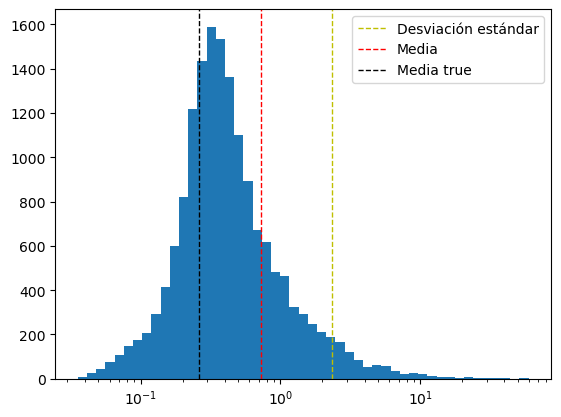

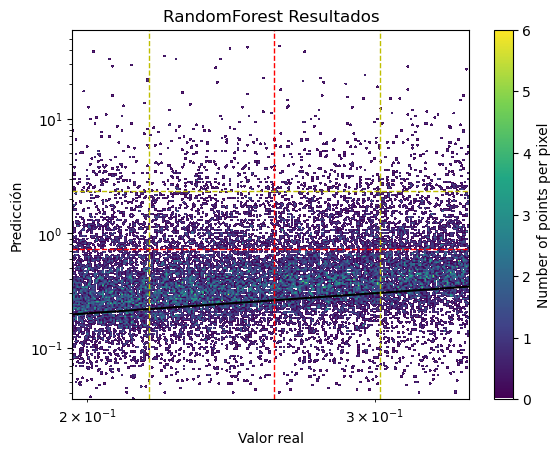

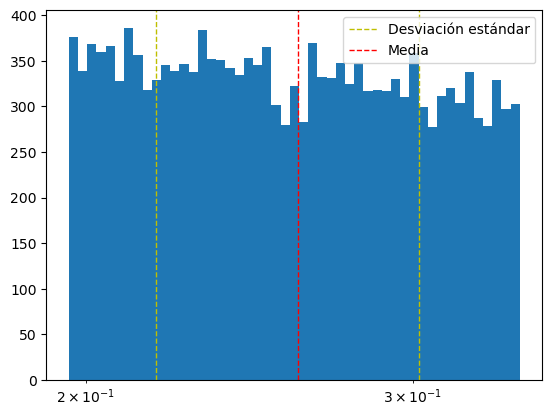

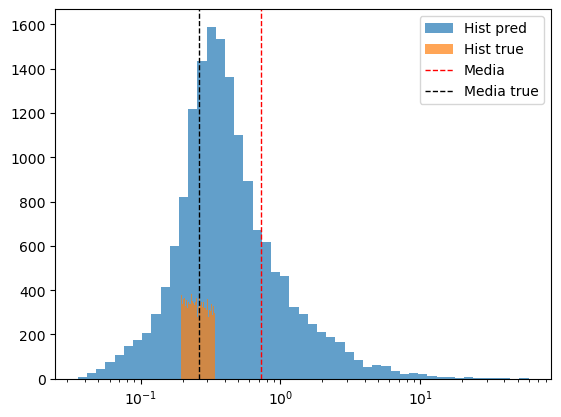

In [10]:
media6 = pred6.mean()
errory6 = pred6.std()
errorx6 = test6.std()
mediatrue6 = test6.mean()

# Calculamos los parámetros de la reconstrucción de energías
x_pred = np.linspace(media6 - 2*errory6, media6 + 2*errory6, 1000)
print ('Mean pred =', media6)
print ('Standard Deviation pred =', errory6)
print ('Skewness pred =', scipy.stats.skew(pred6))
print ('Kurtosis pred =', scipy.stats.kurtosis(pred6))

# Calculamos los parámetros de las energías verdaderas
x_test = np.linspace(mediatrue6 - 2*errorx6, mediatrue6 + 2*errorx6, 1000)
print ('Mean test =', mediatrue6)
print ('Standard Deviation test =', errorx6)
print ('Skewness test =', scipy.stats.skew(test6))
print ('Kurtosis test =', scipy.stats.kurtosis(test6))

# Represenatamos el histograma de la reconstrucción de energías
plt.hist(pred6, np.geomspace(pred6.min(), pred6.max(), num=50), range=(pred6.min(), pred6.max()))
plt.xscale('log')
plt.axvline(-errory6 + media6, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errory6 + media6, color='y', linestyle='dashed', linewidth=1)
plt.axvline(media6, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue6, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.legend()
plt.show()

# Representamos la reconstrucción frente a los valores reales
fig = plt.figure()
using_mpl_scatter_density(fig, test6, pred6)
plt.axline((1, 1), slope=1, c="k")
plt.title("RandomForest Resultados")
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.yscale('log')
plt.xscale('log')
plt.axvline(-errorx6 + mediatrue6, color='y', linestyle='dashed', linewidth=1, label='Std true')
plt.axvline(errorx6 + mediatrue6, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue6, color='r', linestyle='dashed', linewidth=1, label='Media true')
plt.axhline(-errory6 + media6, color='y', linestyle='dashed', linewidth=1, label='Std pred')
plt.axhline(errory6 + media6, color='y', linestyle='dashed', linewidth=1)
plt.axhline(media6, color='r', linestyle='dashed', linewidth=1, label='Media pred')
plt.xlim(test6.min(), test6.max())
plt.show()

# Representamos el histograma de las energías verdaderas
plt.hist(test6, np.geomspace(test6.min(), test6.max(), num=50), range=(test6.min(), test6.max()))
plt.xscale('log')
plt.axvline(-errorx6 + mediatrue6, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errorx6 + mediatrue6, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue6, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.legend()
plt.show()
plt.show()

# Representamos los dos histogramas
plt.hist(pred6, np.geomspace(pred6.min(), pred6.max(), num=50), range=(pred6.min(), pred6.max()), alpha = 0.7, label = 'Hist pred')
plt.hist(test6, np.geomspace(test6.min(), test6.max(), num=50), range=(test6.min(), test6.max()), alpha = 0.7, label = 'Hist true')
plt.xscale('log')
plt.axvline(media6, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue6, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.xscale('log')
plt.legend()
plt.show()

# Añadimos la media y los errores para el plot final
media.append(media6)
mediatrue.append(mediatrue6)
errory.append(errory6)
errorx.append(errorx6)

Mean pred = 1.0943619014488482
Standard Deviation pred = 2.054171391056652
Skewness pred = 16.207132200424947
Kurtosis pred = 444.7016853949555
Mean test = 0.4831447367136295
Standard Deviation test = 0.09285272307134362
Skewness test = 0.3069964061989671
Kurtosis test = -1.0707913587423552


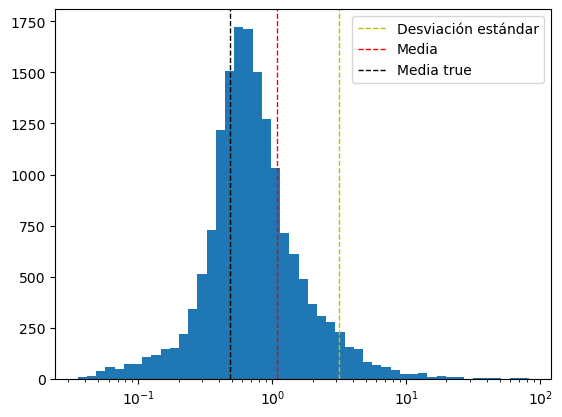

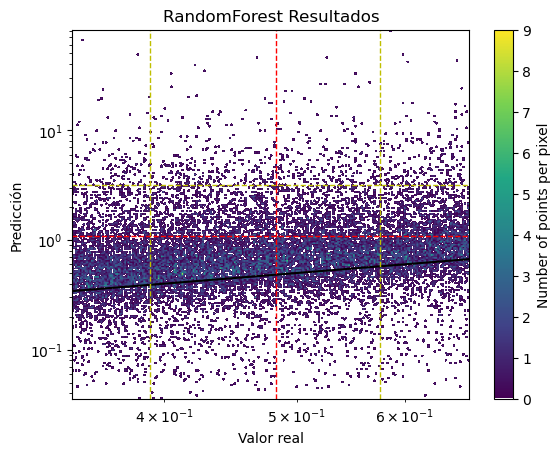

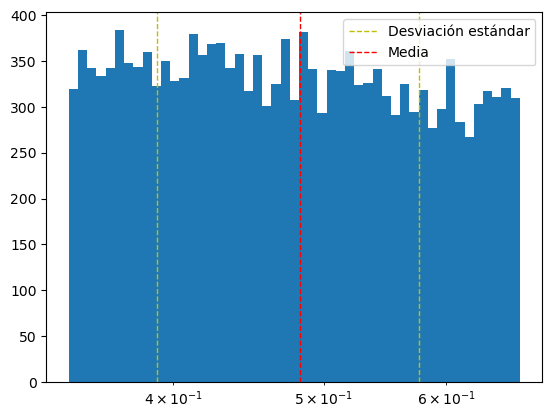

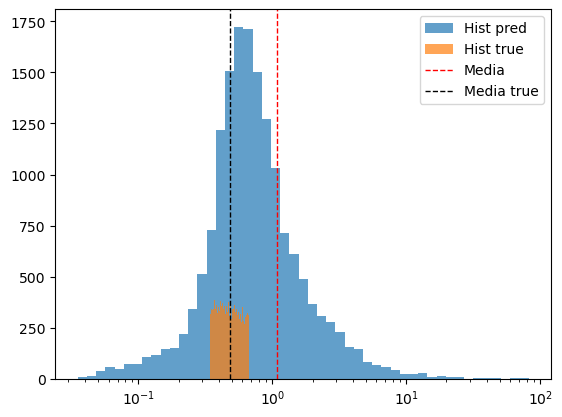

In [11]:
media7 = pred7.mean()
errory7 = pred7.std()
errorx7 = test7.std()
mediatrue7 = test7.mean()

# Calculamos los parámetros de la reconstrucción de energías
x_pred = np.linspace(media7 - 2*errory7, media7 + 2*errory7, 1000)
print ('Mean pred =', media7)
print ('Standard Deviation pred =', errory7)
print ('Skewness pred =', scipy.stats.skew(pred7))
print ('Kurtosis pred =', scipy.stats.kurtosis(pred7))

# Calculamos los parámetros de las energías verdaderas
x_test = np.linspace(mediatrue7 - 2*errorx7, mediatrue7 + 2*errorx7, 1000)
print ('Mean test =', mediatrue7)
print ('Standard Deviation test =', errorx7)
print ('Skewness test =', scipy.stats.skew(test7))
print ('Kurtosis test =', scipy.stats.kurtosis(test7))

# Represenatamos el histograma de la reconstrucción de energías
plt.hist(pred7, np.geomspace(pred7.min(), pred7.max(), num=50), range=(pred7.min(), pred7.max()))
plt.xscale('log')
plt.axvline(-errory7 + media7, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errory7 + media7, color='y', linestyle='dashed', linewidth=1)
plt.axvline(media7, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue7, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.legend()
plt.show()

# Representamos la reconstrucción frente a los valores reales
fig = plt.figure()
using_mpl_scatter_density(fig, test7, pred7)
plt.axline((1, 1), slope=1, c="k")
plt.title("RandomForest Resultados")
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.yscale('log')
plt.xscale('log')
plt.axvline(-errorx7 + mediatrue7, color='y', linestyle='dashed', linewidth=1, label='Std true')
plt.axvline(errorx7 + mediatrue7, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue7, color='r', linestyle='dashed', linewidth=1, label='Media true')
plt.axhline(-errory7 + media7, color='y', linestyle='dashed', linewidth=1, label='Std pred')
plt.axhline(errory7 + media7, color='y', linestyle='dashed', linewidth=1)
plt.axhline(media7, color='r', linestyle='dashed', linewidth=1, label='Media pred')
plt.xlim(test7.min(), test7.max())
plt.show()

# Representamos el histograma de las energías verdaderas
plt.hist(test7, np.geomspace(test7.min(), test7.max(), num=50), range=(test7.min(), test7.max()))
plt.xscale('log')
plt.axvline(-errorx7 + mediatrue7, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errorx7 + mediatrue7, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue7, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.legend()
plt.show()
plt.show()

# Representamos los dos histogramas
plt.hist(pred7, np.geomspace(pred7.min(), pred7.max(), num=50), range=(pred7.min(), pred7.max()), alpha = 0.7, label = 'Hist pred')
plt.hist(test7, np.geomspace(test7.min(), test7.max(), num=50), range=(test7.min(), test7.max()), alpha = 0.7, label = 'Hist true')
plt.xscale('log')
plt.axvline(media7, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue7, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.xscale('log')
plt.legend()
plt.show()

# Añadimos la media y los errores para el plot final
media.append(media7)
mediatrue.append(mediatrue7)
errory.append(errory7)
errorx.append(errorx7)

Mean pred = 1.8933279746411251
Standard Deviation pred = 2.5860539517819894
Skewness pred = 10.139017408002756
Kurtosis pred = 180.53803533851277
Mean test = 1.046011602808879
Standard Deviation test = 0.2632996072476576
Skewness test = 0.3921510434574708
Kurtosis test = -1.0034898825781553


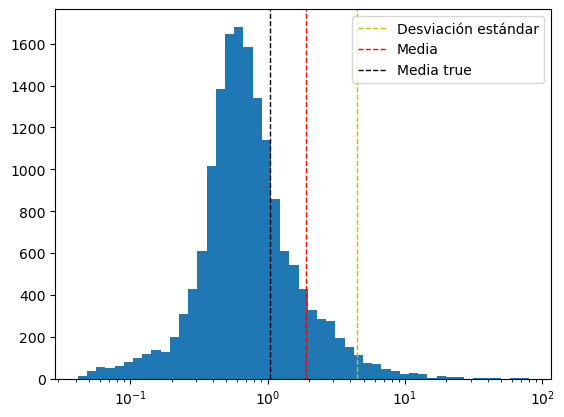

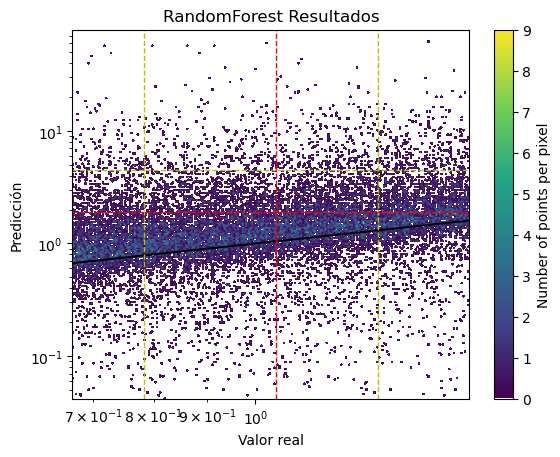

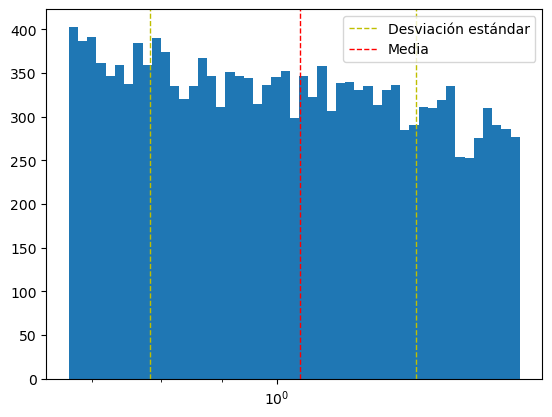

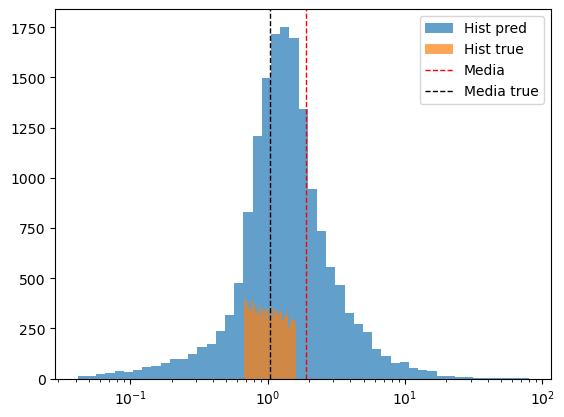

In [12]:
media8 = pred8.mean()
errory8 = pred8.std()
errorx8 = test8.std()
mediatrue8 = test8.mean()

# Calculamos los parámetros de la reconstrucción de energías
x_pred = np.linspace(media8 - 2*errory8, media8 + 2*errory8, 1000)
print ('Mean pred =', media8)
print ('Standard Deviation pred =', errory8)
print ('Skewness pred =', scipy.stats.skew(pred8))
print ('Kurtosis pred =', scipy.stats.kurtosis(pred8))

# Calculamos los parámetros de las energías verdaderas
x_test = np.linspace(mediatrue8 - 2*errorx8, mediatrue8 + 2*errorx8, 1000)
print ('Mean test =', mediatrue8)
print ('Standard Deviation test =', errorx8)
print ('Skewness test =', scipy.stats.skew(test8))
print ('Kurtosis test =', scipy.stats.kurtosis(test8))

# Represenatamos el histograma de la reconstrucción de energías
plt.hist(pred7, np.geomspace(pred8.min(), pred8.max(), num=50), range=(pred8.min(), pred8.max()))
plt.xscale('log')
plt.axvline(-errory8 + media8, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errory8 + media8, color='y', linestyle='dashed', linewidth=1)
plt.axvline(media8, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue8, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.legend()
plt.show()

# Representamos la reconstrucción frente a los valores reales
fig = plt.figure()
using_mpl_scatter_density(fig, test8, pred8)
plt.axline((1, 1), slope=1, c="k")
plt.title("RandomForest Resultados")
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.yscale('log')
plt.xscale('log')
plt.axvline(-errorx8 + mediatrue8, color='y', linestyle='dashed', linewidth=1, label='Std true')
plt.axvline(errorx8 + mediatrue8, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue8, color='r', linestyle='dashed', linewidth=1, label='Media true')
plt.axhline(-errory8 + media8, color='y', linestyle='dashed', linewidth=1, label='Std pred')
plt.axhline(errory8 + media8, color='y', linestyle='dashed', linewidth=1)
plt.axhline(media8, color='r', linestyle='dashed', linewidth=1, label='Media pred')
plt.xlim(test8.min(), test8.max())
plt.show()

# Representamos el histograma de las energías verdaderas
plt.hist(test8, np.geomspace(test8.min(), test8.max(), num=50), range=(test8.min(), test8.max()))
plt.xscale('log')
plt.axvline(-errorx8 + mediatrue8, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errorx8 + mediatrue8, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue8, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.legend()
plt.show()
plt.show()

# Representamos los dos histogramas
plt.hist(pred8, np.geomspace(pred8.min(), pred8.max(), num=50), range=(pred8.min(), pred8.max()), alpha = 0.7, label = 'Hist pred')
plt.hist(test8, np.geomspace(test8.min(), test8.max(), num=50), range=(test8.min(), test8.max()), alpha = 0.7, label = 'Hist true')
plt.xscale('log')
plt.axvline(media8, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue8, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.xscale('log')
plt.legend()
plt.show()

# Añadimos la media y los errores para el plot final
media.append(media8)
mediatrue.append(mediatrue8)
errory.append(errory8)
errorx.append(errorx8)

Mean pred = 4.403922124327872
Standard Deviation pred = 4.2657388063603685
Skewness pred = 5.052033818184827
Kurtosis pred = 46.51596806440533
Mean test = 3.069881457622235
Standard Deviation test = 1.1416080936440753
Skewness test = 0.6341263255410795
Kurtosis test = -0.7097736776904053


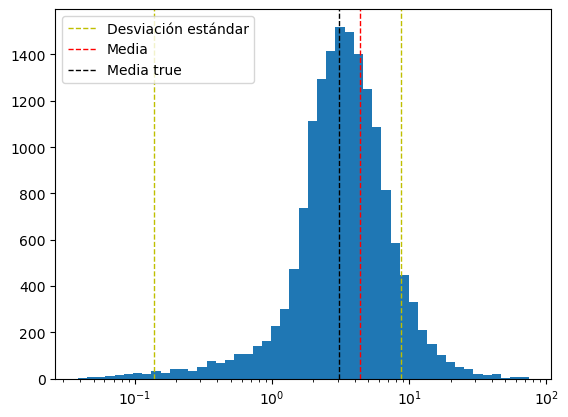

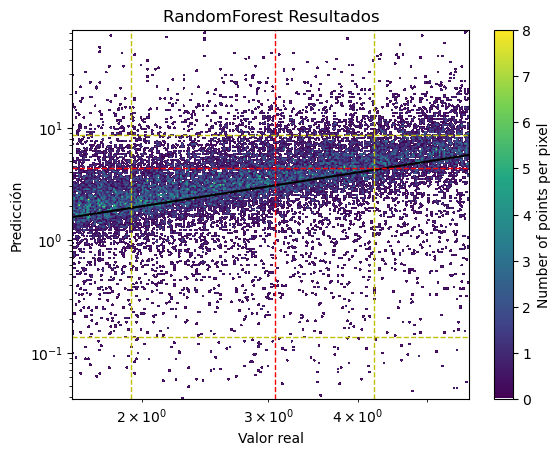

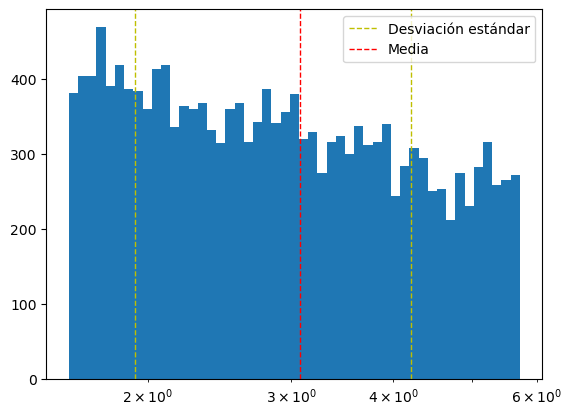

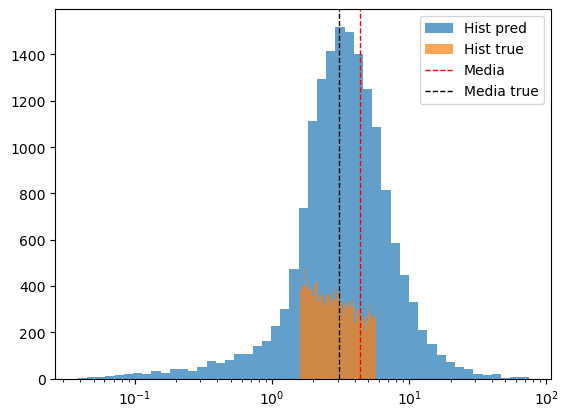

In [13]:
media9 = pred9.mean()
errory9 = pred9.std()
errorx9 = test9.std()
mediatrue9 = test9.mean()

# Calculamos los parámetros de la reconstrucción de energías
x_pred = np.linspace(media9 - 2*errory9, media9 + 2*errory9, 1000)
print ('Mean pred =', media9)
print ('Standard Deviation pred =', errory9)
print ('Skewness pred =', scipy.stats.skew(pred9))
print ('Kurtosis pred =', scipy.stats.kurtosis(pred9))

# Calculamos los parámetros de las energías verdaderas
x_test = np.linspace(mediatrue9 - 2*errorx9, mediatrue9 + 2*errorx9, 1000)
print ('Mean test =', mediatrue9)
print ('Standard Deviation test =', errorx9)
print ('Skewness test =', scipy.stats.skew(test9))
print ('Kurtosis test =', scipy.stats.kurtosis(test9))

# Represenatamos el histograma de la reconstrucción de energías
plt.hist(pred9, np.geomspace(pred9.min(), pred9.max(), num=50), range=(pred9.min(), pred9.max()))
plt.xscale('log')
plt.axvline(-errory9 + media9, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errory9 + media9, color='y', linestyle='dashed', linewidth=1)
plt.axvline(media9, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue9, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.legend()
plt.show()

# Representamos la reconstrucción frente a los valores reales
fig = plt.figure()
using_mpl_scatter_density(fig, test9, pred9)
plt.axline((1, 1), slope=1, c="k")
plt.title("RandomForest Resultados")
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.yscale('log')
plt.xscale('log')
plt.axvline(-errorx9 + mediatrue9, color='y', linestyle='dashed', linewidth=1, label='Std true')
plt.axvline(errorx9 + mediatrue9, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue9, color='r', linestyle='dashed', linewidth=1, label='Media true')
plt.axhline(-errory9 + media9, color='y', linestyle='dashed', linewidth=1, label='Std pred')
plt.axhline(errory9 + media9, color='y', linestyle='dashed', linewidth=1)
plt.axhline(media9, color='r', linestyle='dashed', linewidth=1, label='Media pred')
plt.xlim(test9.min(), test9.max())
plt.show()

# Representamos el histograma de las energías verdaderas
plt.hist(test9, np.geomspace(test9.min(), test9.max(), num=50), range=(test9.min(), test9.max()))
plt.xscale('log')
plt.axvline(-errorx9 + mediatrue9, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errorx9 + mediatrue9, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue9, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.legend()
plt.show()
plt.show()

# Representamos los dos histogramas
plt.hist(pred9, np.geomspace(pred9.min(), pred9.max(), num=50), range=(pred9.min(), pred9.max()), alpha = 0.7, label = 'Hist pred')
plt.hist(test9, np.geomspace(test9.min(), test9.max(), num=50), range=(test9.min(), test9.max()), alpha = 0.7, label = 'Hist true')
plt.xscale('log')
plt.axvline(media9, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue9, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.xscale('log')
plt.legend()
plt.show()

# Añadimos la media y los errores para el plot final
media.append(media9)
mediatrue.append(mediatrue9)
errory.append(errory9)
errorx.append(errorx9)

Mean pred = 32.587764558017675
Standard Deviation pred = 38.634979355437736
Skewness pred = 2.222516889783651
Kurtosis pred = 5.259549017020483
Mean test = 36.898014090156124
Standard Deviation test = 50.55004488428368
Skewness test = 2.936443852832049
Kurtosis test = 9.658795632841649


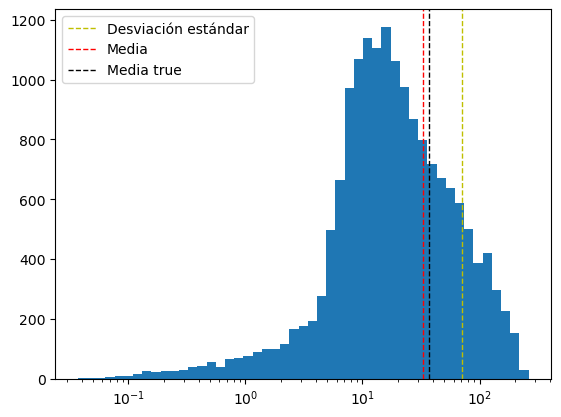

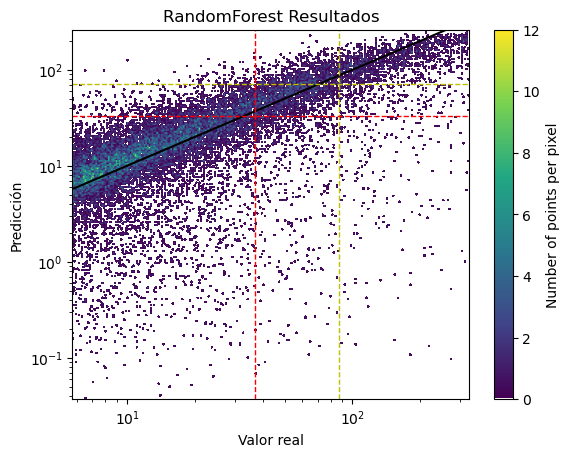

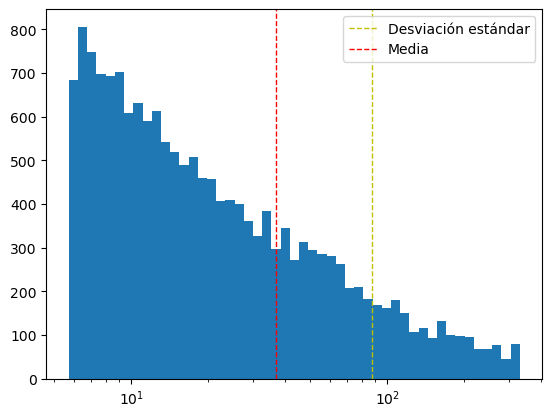

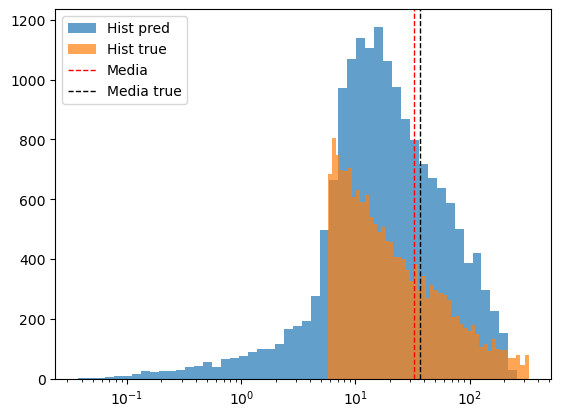

In [14]:
media10 = pred10.mean()
errory10 = pred10.std()
errorx10 = test10.std()
mediatrue10 = test10.mean()

# Calculamos los parámetros de la reconstrucción de energías
x_pred = np.linspace(media10 - 2*errory10, media10 + 2*errory10, 1000)
print ('Mean pred =', media10)
print ('Standard Deviation pred =', errory10)
print ('Skewness pred =', scipy.stats.skew(pred10))
print ('Kurtosis pred =', scipy.stats.kurtosis(pred10))

# Calculamos los parámetros de las energías verdaderas
x_test = np.linspace(mediatrue10 - 2*errorx10, mediatrue10 + 2*errorx10, 1000)
print ('Mean test =', mediatrue10)
print ('Standard Deviation test =', errorx10)
print ('Skewness test =', scipy.stats.skew(test10))
print ('Kurtosis test =', scipy.stats.kurtosis(test10))

# Represenatamos el histograma de la reconstrucción de energías
plt.hist(pred10, np.geomspace(pred10.min(), pred10.max(), num=50), range=(pred10.min(), pred10.max()))
plt.xscale('log')
plt.axvline(-errory10 + media10, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errory10 + media10, color='y', linestyle='dashed', linewidth=1)
plt.axvline(media10, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue10, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.legend()
plt.show()

# Representamos la reconstrucción frente a los valores reales
fig = plt.figure()
using_mpl_scatter_density(fig, test10, pred10)
plt.axline((1, 1), slope=1, c="k")
plt.title("RandomForest Resultados")
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.yscale('log')
plt.xscale('log')
plt.axvline(-errorx10 + mediatrue10, color='y', linestyle='dashed', linewidth=1, label='Std true')
plt.axvline(errorx10 + mediatrue10, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue10, color='r', linestyle='dashed', linewidth=1, label='Media true')
plt.axhline(-errory10 + media10, color='y', linestyle='dashed', linewidth=1, label='Std pred')
plt.axhline(errory10 + media10, color='y', linestyle='dashed', linewidth=1)
plt.axhline(media10, color='r', linestyle='dashed', linewidth=1, label='Media pred')
plt.xlim(test10.min(), test10.max())
plt.show()

# Representamos el histograma de las energías verdaderas
plt.hist(test10, np.geomspace(test10.min(), test10.max(), num=50), range=(test10.min(), test10.max()))
plt.xscale('log')
plt.axvline(-errorx10 + mediatrue10, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errorx10 + mediatrue10, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrue10, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.legend()
plt.show()
plt.show()

# Representamos los dos histogramas
plt.hist(pred10, np.geomspace(pred10.min(), pred10.max(), num=50), range=(pred10.min(), pred10.max()), alpha = 0.7, label = 'Hist pred')
plt.hist(test10, np.geomspace(test10.min(), test10.max(), num=50), range=(test10.min(), test10.max()), alpha = 0.7, label = 'Hist true')
plt.xscale('log')
plt.axvline(media10, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrue10, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.xscale('log')
plt.legend()
plt.show()

# Añadimos la media y los errores para el plot final
media.append(media10)
mediatrue.append(mediatrue10)
errory.append(errory10)
errorx.append(errorx10)

Mean pred = 4.340729151430582
Standard Deviation pred = 15.807472581076054
Skewness pred = 7.22649886384235
Kurtosis pred = 64.10675232811231
Mean test = 4.311151054288788
Standard Deviation test = 19.62835956601666
Skewness test = 9.028141832444337
Kurtosis test = 100.8346685822768


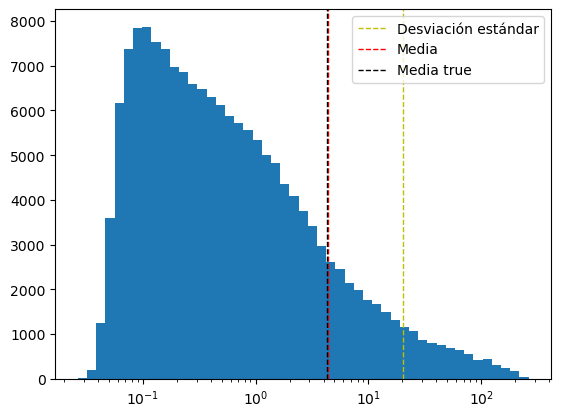

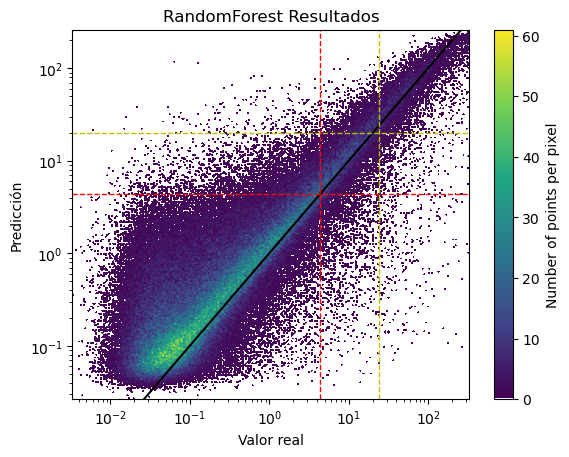

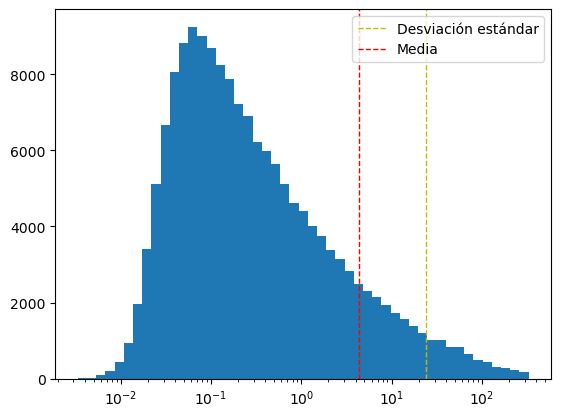

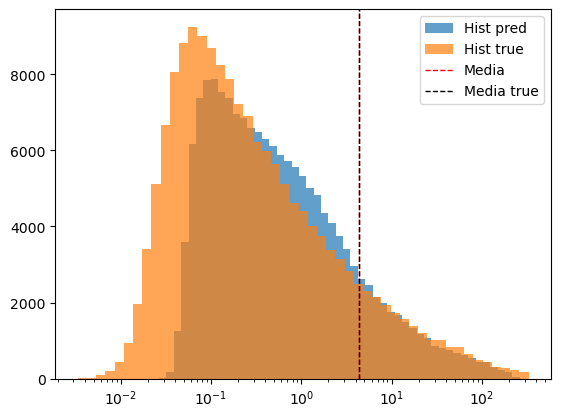

In [15]:
mediaT = y_pred.mean()
erroryT = y_pred.std()
errorxT = y_test.std()
mediatrueT = y_test.mean()

# Calculamos los parámetros de la reconstrucción de energías
x_pred = np.linspace(mediaT - 2*erroryT, mediaT + 2*erroryT, 1000)
print ('Mean pred =', mediaT)
print ('Standard Deviation pred =', erroryT)
print ('Skewness pred =', scipy.stats.skew(y_pred))
print ('Kurtosis pred =', scipy.stats.kurtosis(y_pred))

# Calculamos los parámetros de las energías verdaderas
x_test = np.linspace(mediatrueT - 2*errorxT, mediatrueT + 2*errorxT, 1000)
print ('Mean test =', mediatrueT)
print ('Standard Deviation test =', errorxT)
print ('Skewness test =', scipy.stats.skew(y_test))
print ('Kurtosis test =', scipy.stats.kurtosis(y_test))

# Represenatamos el histograma de la reconstrucción de energías
plt.hist(y_pred, np.geomspace(y_pred.min(), y_pred.max(), num=50), range=(y_pred.min(), y_pred.max()))
plt.xscale('log')
plt.axvline(-erroryT + mediaT, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(erroryT + mediaT, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediaT, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrueT, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.legend()
plt.show()

# Representamos la reconstrucción frente a los valores reales
fig = plt.figure()
using_mpl_scatter_density(fig, y_test, y_pred)
plt.axline((1, 1), slope=1, c="k")
plt.title("RandomForest Resultados")
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.yscale('log')
plt.xscale('log')
plt.axvline(-errorxT + mediatrueT, color='y', linestyle='dashed', linewidth=1, label='Std true')
plt.axvline(errorxT + mediatrueT, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrueT, color='r', linestyle='dashed', linewidth=1, label='Media true')
plt.axhline(-erroryT + mediaT, color='y', linestyle='dashed', linewidth=1, label='Std pred')
plt.axhline(erroryT + mediaT, color='y', linestyle='dashed', linewidth=1)
plt.axhline(mediaT, color='r', linestyle='dashed', linewidth=1, label='Media pred')
plt.xlim(y_test.min(), y_test.max())
plt.show()

# Representamos el histograma de las energías verdaderas
plt.hist(y_test, np.geomspace(y_test.min(), y_test.max(), num=50), range=(y_test.min(), y_test.max()))
plt.xscale('log')
plt.axvline(-errorxT + mediatrueT, color='y', linestyle='dashed', linewidth=1, label='Desviación estándar')
plt.axvline(errorxT + mediatrueT, color='y', linestyle='dashed', linewidth=1)
plt.axvline(mediatrueT, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.legend()
plt.show()
plt.show()

# Representamos los dos histogramas
plt.hist(y_pred, np.geomspace(y_pred.min(), y_pred.max(), num=50), range=(y_pred.min(), y_pred.max()), alpha = 0.7, label = 'Hist pred')
plt.hist(y_test, np.geomspace(y_test.min(), y_test.max(), num=50), range=(y_test.min(), y_test.max()), alpha = 0.7, label = 'Hist true')
plt.xscale('log')
plt.axvline(mediaT, color='r', linestyle='dashed', linewidth=1, label='Media')
plt.axvline(mediatrueT, color='k', linestyle='dashed', linewidth=1, label='Media true')
plt.xscale('log')
plt.legend()
plt.show()

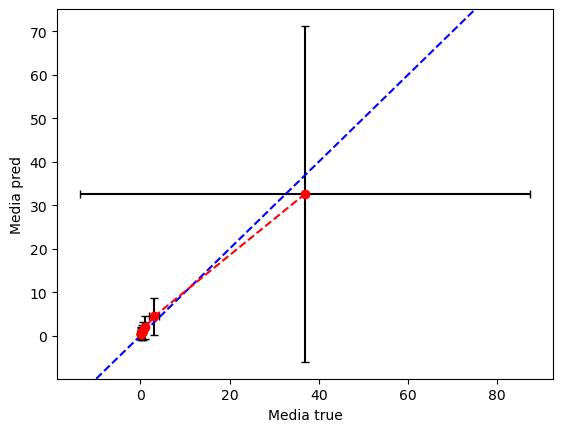

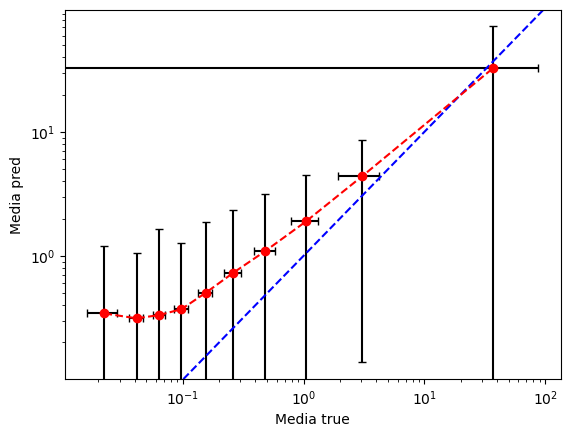

In [16]:
plt.errorbar(mediatrue, media, errory, errorx, capsize=3, fmt="r--o", ecolor = "black")
plt.axline((1, 1), slope=1, c="b", linestyle='dashed')
plt.xlabel('Media true')
plt.ylabel('Media pred')
plt.show()

plt.errorbar(mediatrue, media, errory, errorx, capsize=3, fmt="r--o", ecolor = "black")
plt.axline((1, 1), slope=1, c="b", linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Media true')
plt.ylabel('Media pred')
plt.show()

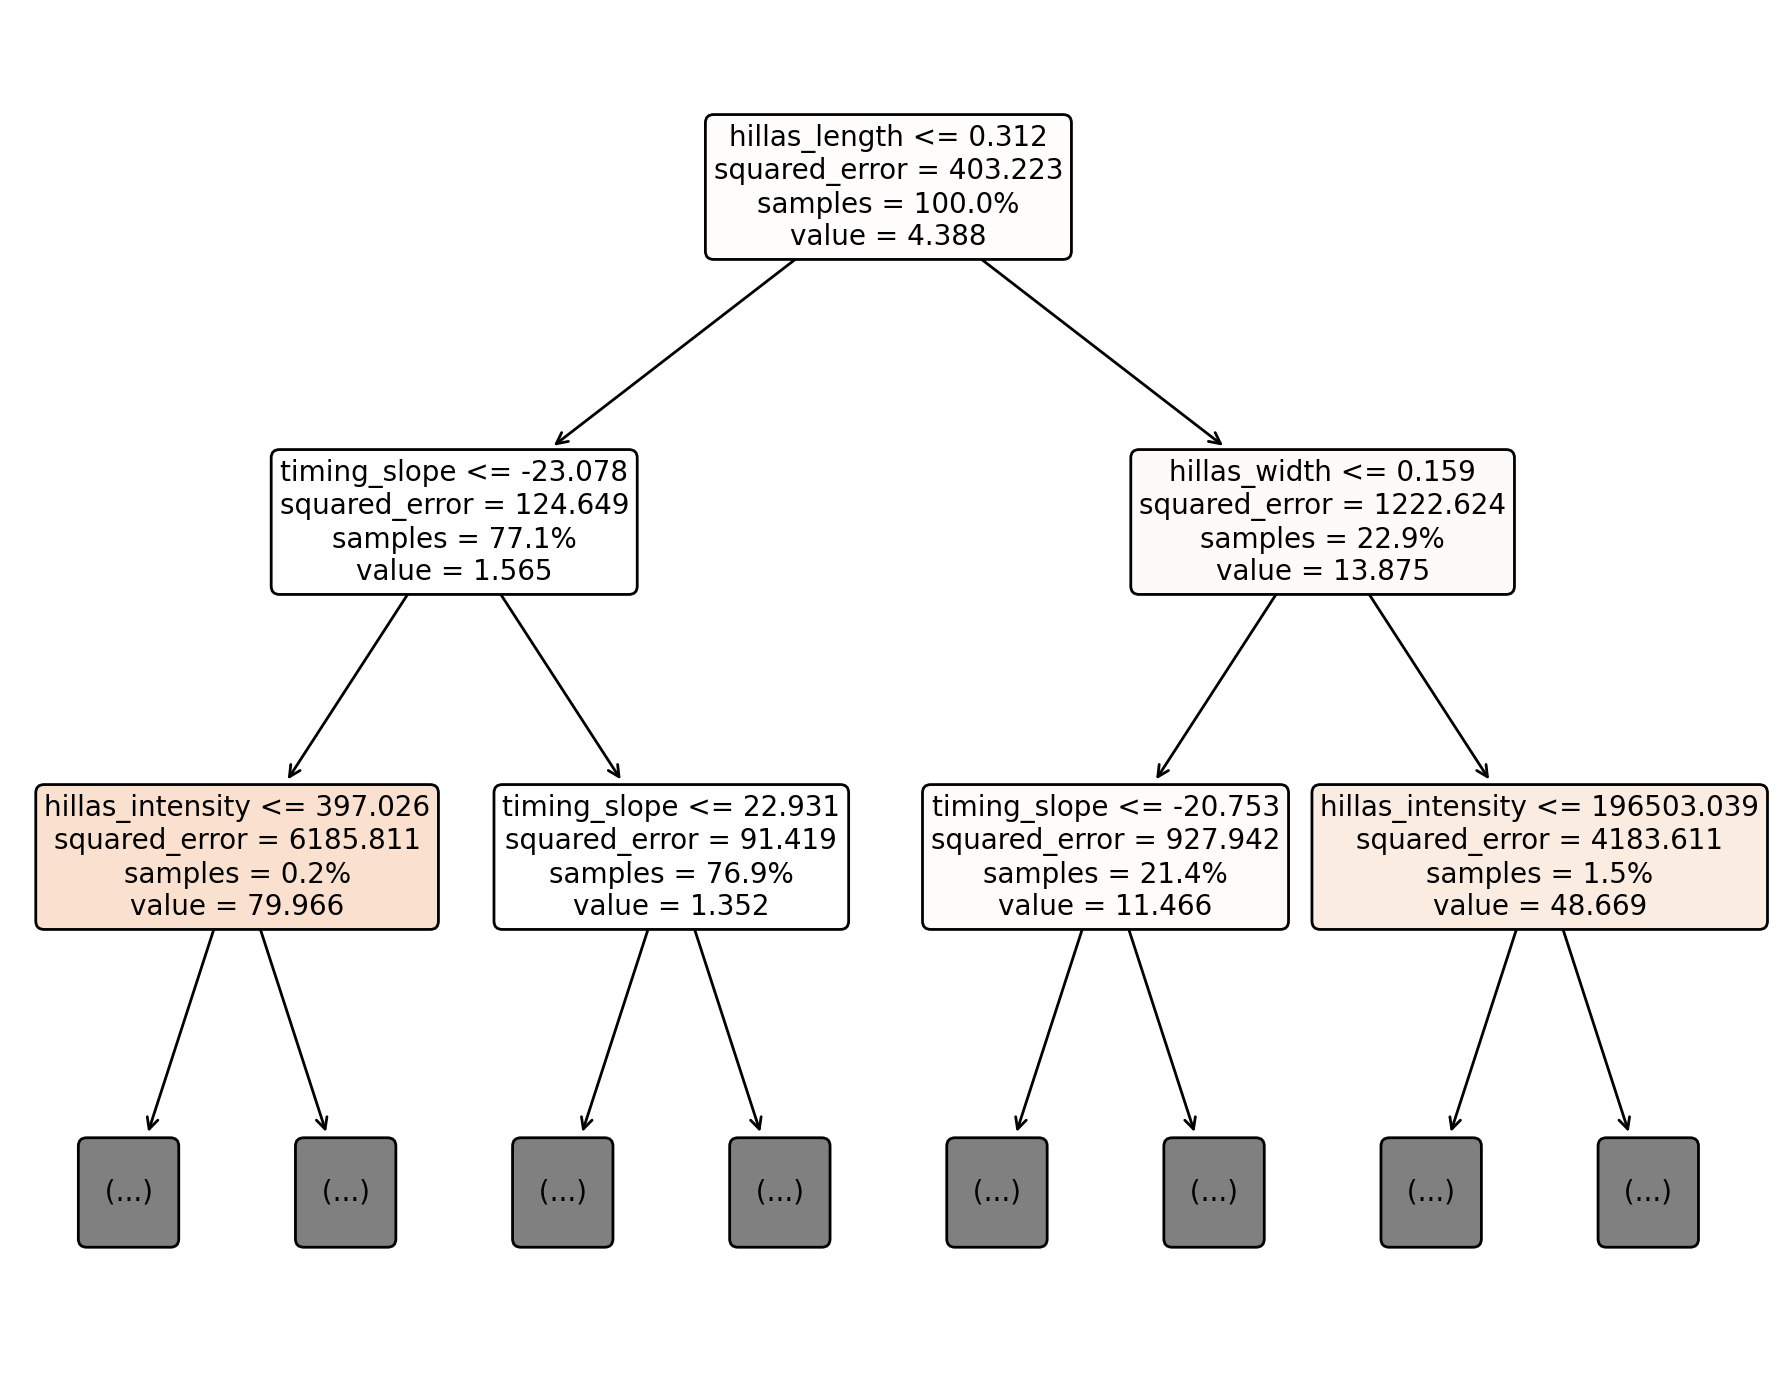

In [47]:
from sklearn.tree import export_graphviz
from sklearn import tree

names = ['hillas_intensity', 'hillas_skewness', 'hillas_kurtosis', 'hillas_length', 'hillas_width', 'timing_slope']

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (9, 7), dpi=200)
tree.plot_tree(rf.estimators_[38],
               feature_names = names,
               filled=True,
               impurity=True, 
               proportion=True,
               max_depth = 2,
               fontsize=10,  # Tamaño de fuente
               rounded=True  # Bordes redondeados
              )
fig.savefig('regressor.png')

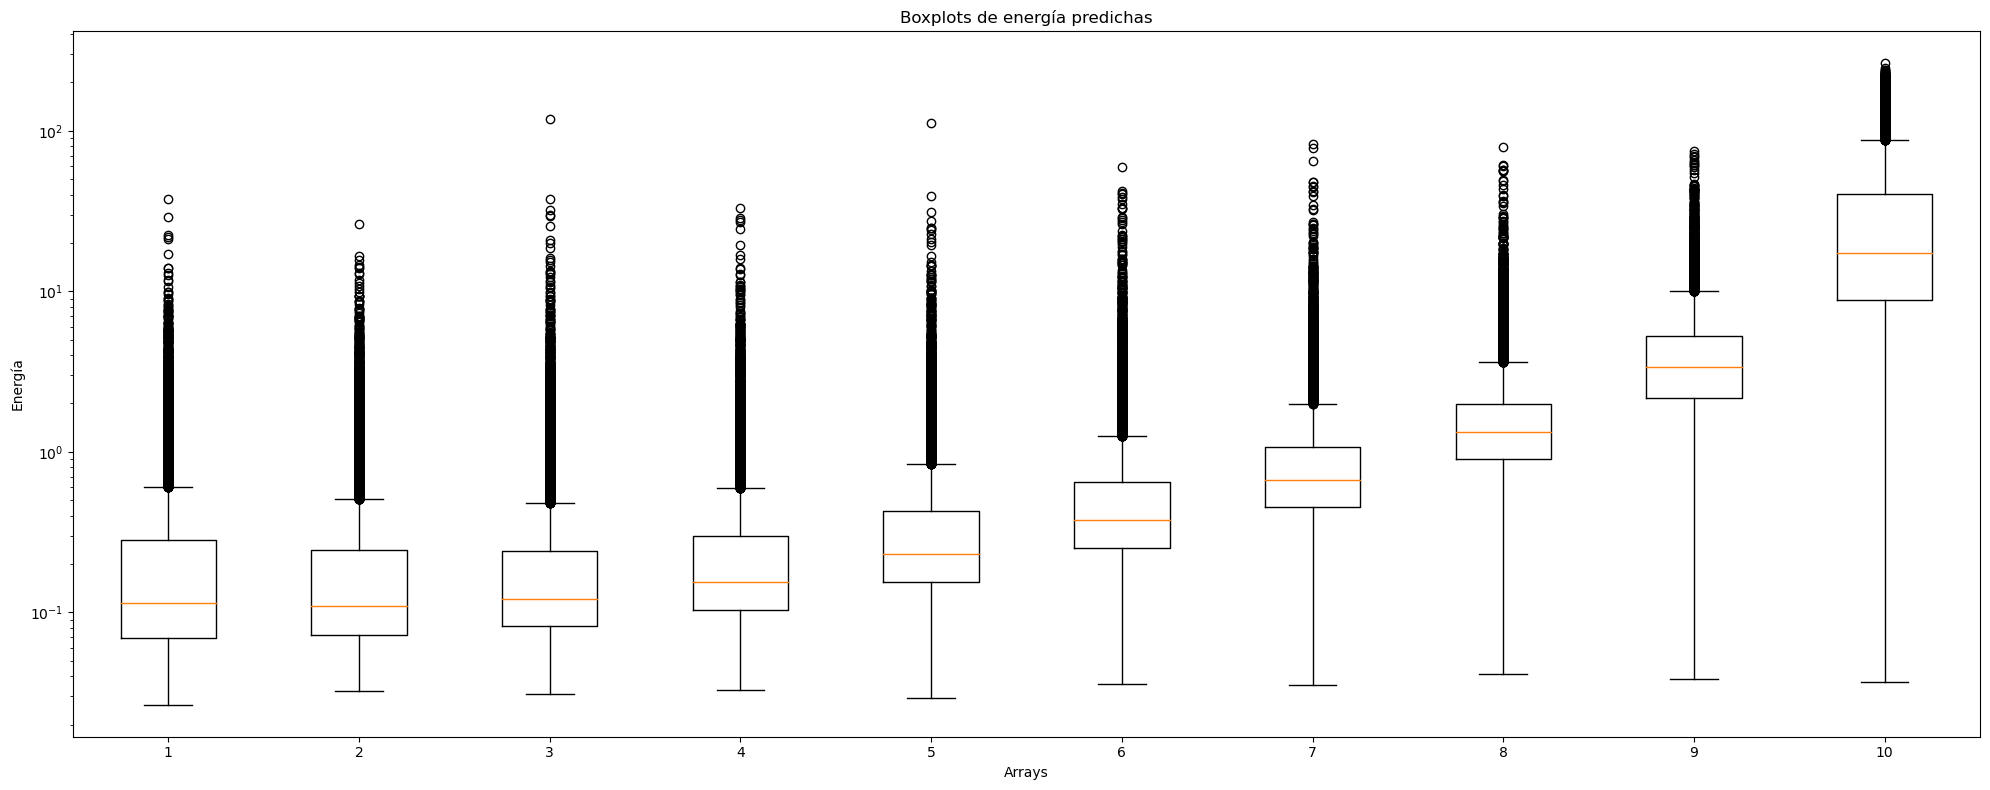

In [32]:
# Voy a hacer unos boxplots que creo que son útiles a la hora de mostrar estos resultados
# Crear la figura y los ejes
fig, ax = plt.subplots()
# Trazar los boxplots para cada array
ax.boxplot([pred1, pred2, pred3, pred4, pred5, pred6, pred7, pred8, pred9, pred10])
# Personalizar la figura
ax.set_title('Boxplots de energía predichas')
ax.set_xlabel('Arrays')
ax.set_ylabel('Energía')
# Mostrar la figura
plt.yscale('log')
plt.show()

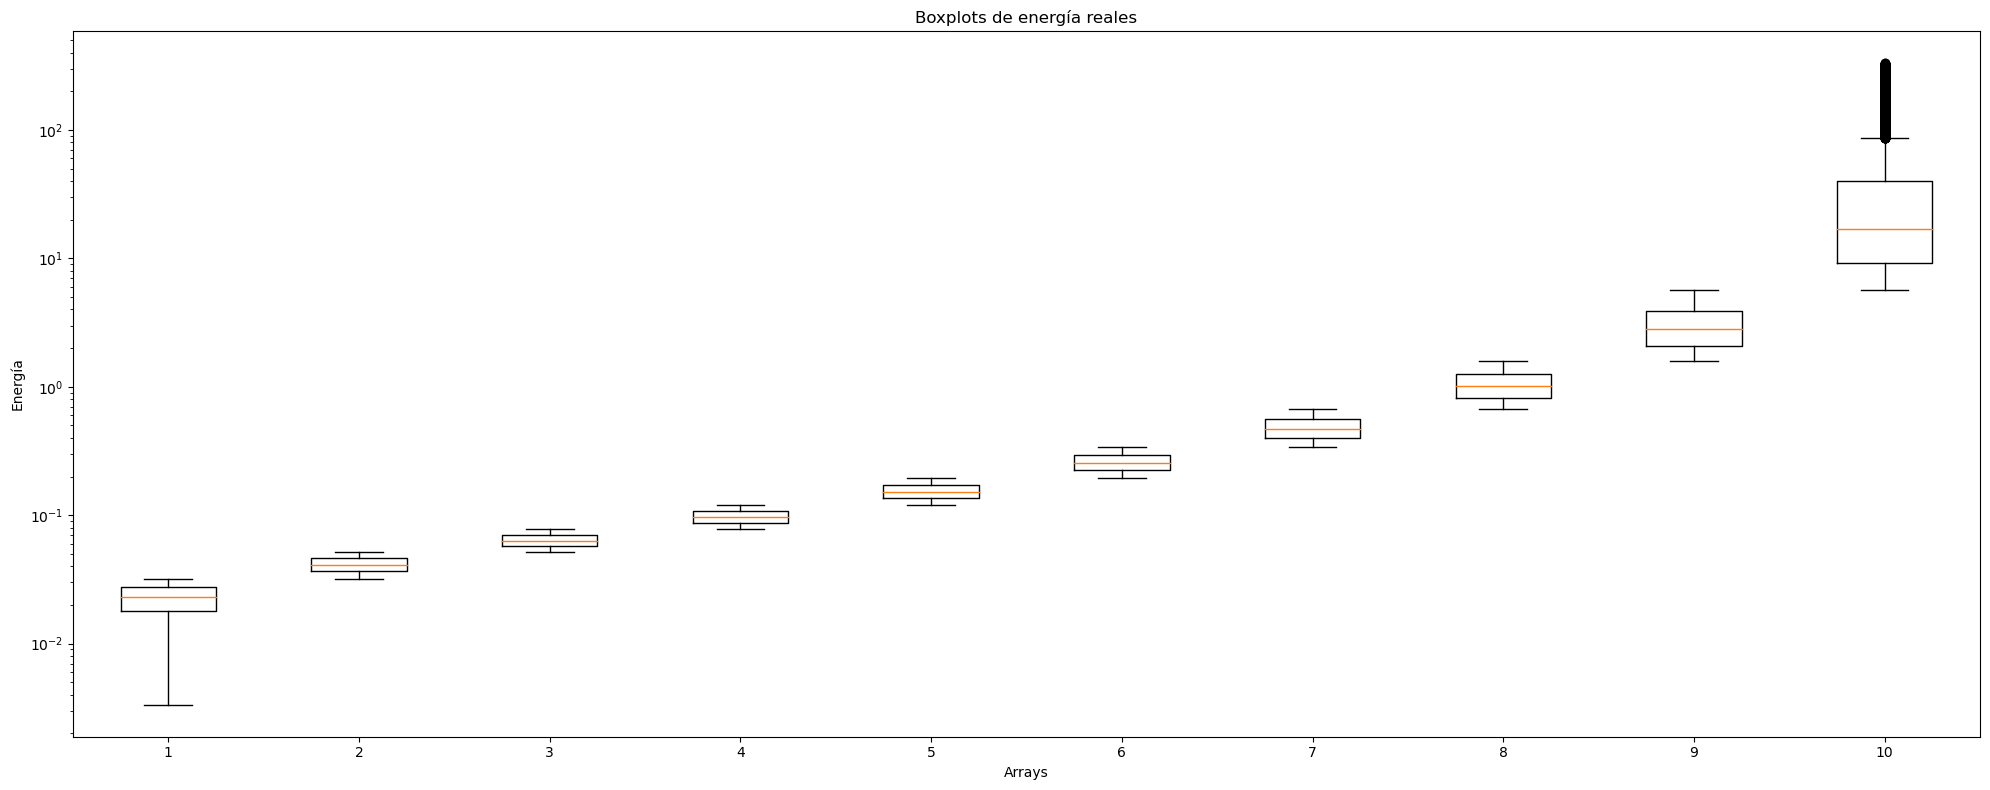

In [34]:
# Crear la figura y los ejes
fig, ax = plt.subplots()
# Trazar los boxplots para cada array
ax.boxplot([test1, test2, test3, test4, test5, test6, test7, test8, test9, test10])
# Personalizar la figura
ax.set_title('Boxplots de energía reales')
ax.set_xlabel('Arrays')
ax.set_ylabel('Energía')
# Mostrar la figura
plt.yscale('log')
plt.show()

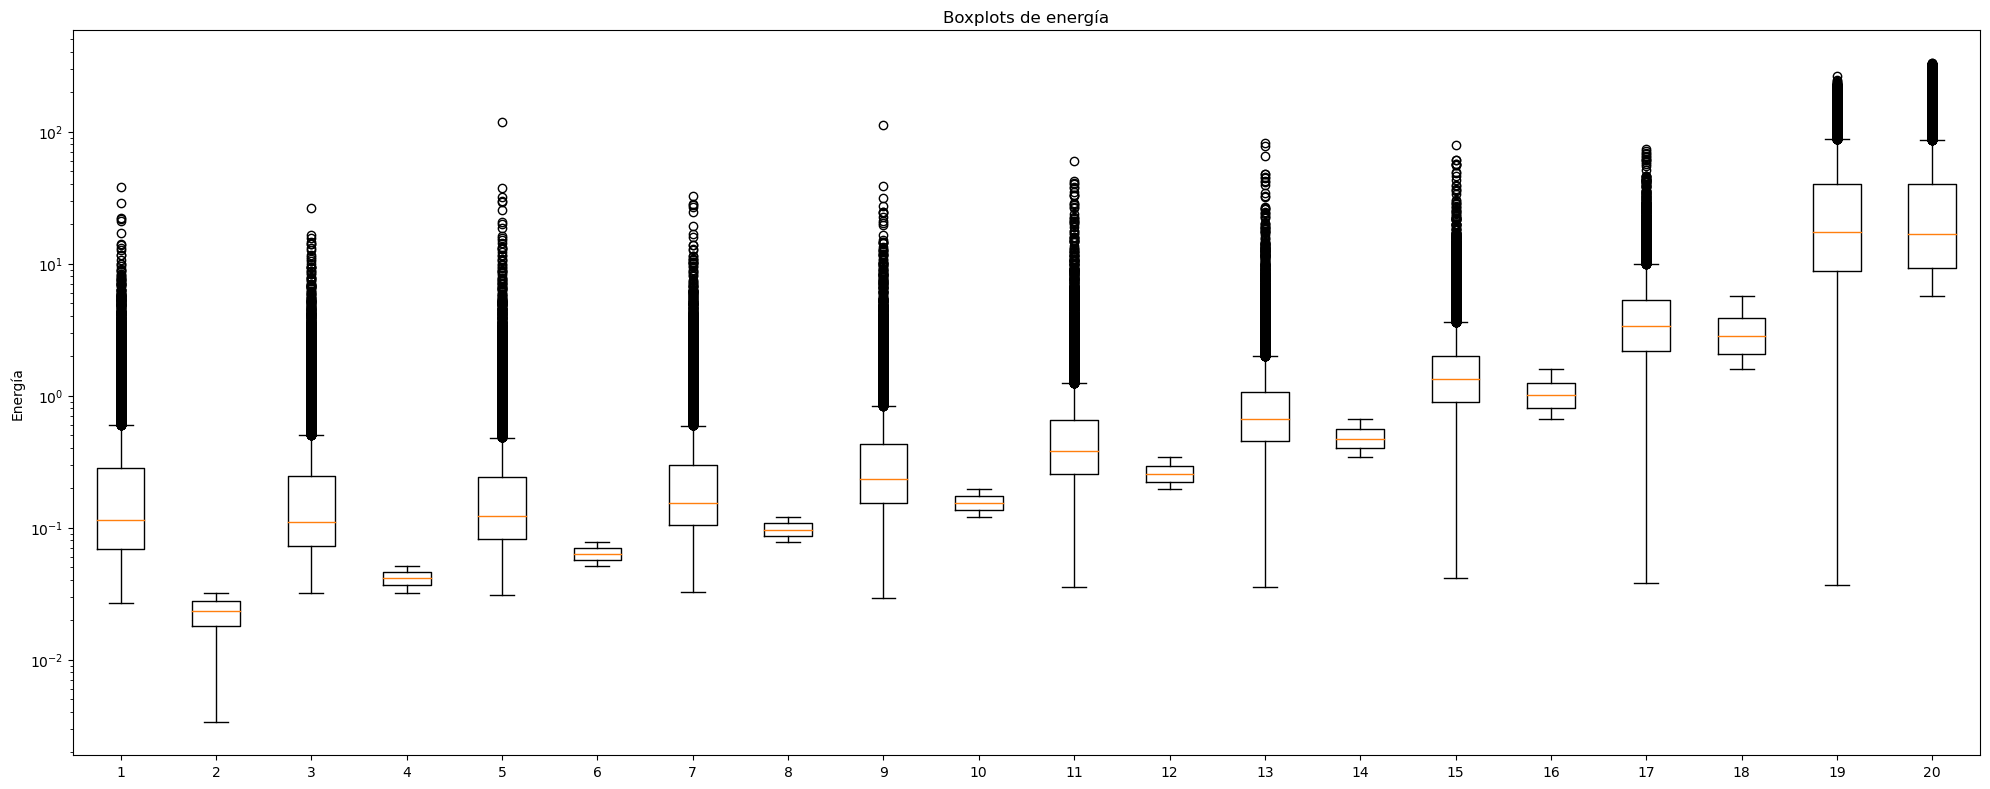

In [35]:
# Crear la figura y los ejes
fig, ax = plt.subplots()
# Trazar los boxplots para cada array
ax.boxplot([pred1, test1, pred2, test2, pred3, test3, pred4, test4, pred5, test5, 
            pred6, test6, pred7, test7, pred8, test8, pred9, test9, pred10, test10])
# Personalizar la figura
ax.set_title('Boxplots de energía')
ax.set_ylabel('Energía')
# Mostrar la figura
plt.yscale('log')
plt.show()